# **Delivery Time Estimation**

#### **Problem**

The business constantly working to improve its service for customers and life and earnings of their delivery partners. They want to evaluate the Estimated Delivery Time on the basis of
- What they are ordering?
- From Where they are ordering
- The availability of Delivery Partners
- etc

> I'll explore the data to find hidden stories and since this is a Regression task, I'll use Neural Networks to estimate the same.

# Data Initialization

In [1]:
# Importing required libraries
from pyspark.sql import SparkSession

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Pyspark Java Setup

# import os

# Set the JAVA_HOME environment variable

# os.environ['JAVA_HOME'] = '/home/studio-lab-user/.conda/envs/delivery_time_torch'
# os.environ['PATH'] = os.environ['JAVA_HOME'] + '/bin:' + os.environ['PATH']

In [4]:
# Initializing Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
# Adjust Spark session settings to improve display
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 50)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 100)
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [6]:
# Investigating Dataset
df = spark.read.csv('../data/raw/data.csv', header=True, inferSchema=True)
display(df.limit(5))

market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NULL,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NULL,1.0,6,6900,5,600,1800,1.0,1.0,2.0
3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NULL,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


In [7]:
# Shape of the dataset

print(f"Shape of DataFrame: (rows: {df.count()}, columns: {len(df.columns)})")

Shape of DataFrame: (rows: 197428, columns: 14)


**Observe**
- We have 14 features and almost 200K datapoints.
- Data seems to be of descent small size.

In [8]:
# Datatypes Info
df.printSchema()

root
 |-- market_id: double (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- actual_delivery_time: timestamp (nullable = true)
 |-- store_id: string (nullable = true)
 |-- store_primary_category: string (nullable = true)
 |-- order_protocol: double (nullable = true)
 |-- total_items: integer (nullable = true)
 |-- subtotal: integer (nullable = true)
 |-- num_distinct_items: integer (nullable = true)
 |-- min_item_price: integer (nullable = true)
 |-- max_item_price: integer (nullable = true)
 |-- total_onshift_partners: double (nullable = true)
 |-- total_busy_partners: double (nullable = true)
 |-- total_outstanding_orders: double (nullable = true)



In [9]:
# Filtering columns on the basis of Data Types

from pyspark.sql.types import StringType, NumericType, TimestampType

continuous_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]
categorical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
temporal_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, TimestampType)]

In [10]:
# Null Values

from pyspark.sql.functions import col, count, when

df.select([count(when(col(c).isNull(),c)).alias(c) for c in df.columns]).toPandas().transpose()/df.count() * 100

,0
market_id,0.499929
created_at,0.000000
actual_delivery_time,0.003546
store_id,0.000000
store_primary_category,2.411006
order_protocol,0.503981
total_items,0.000000
subtotal,0.000000
num_distinct_items,0.000000
min_item_price,0.000000


**Observe**
- Need to treat many Null Values, Cannot drop.

In [11]:
# Statistics Summary
df.select(*continuous_cols).summary().toPandas().transpose()

,0,1,2,3,4,5,6,7
summary,count,mean,stddev,min,25%,50%,75%,max
market_id,196441,2.978706074597462,1.5248667244506318,1.0,2.0,3.0,4.0,6.0
order_protocol,196433,2.8823517433425137,1.5037712034995814,1.0,1.0,3.0,4.0,7.0
total_items,197428,3.196390582896043,2.666546063599881,1,2,3,4,411
subtotal,197428,2682.331401827502,1823.0936878547877,0,1400,2200,3395,27100
num_distinct_items,197428,2.6707913771096297,1.6302552413381575,1,1,2,3,20
min_item_price,197428,686.2184695180015,522.0386476914739,-86,299,595,949,14700
max_item_price,197428,1159.5886297789573,558.4113766592682,0,800,1095,1395,14700
total_onshift_partners,181166,44.808093130057514,34.5267834762135,-4.0,17.0,37.0,65.0,171.0
total_busy_partners,181166,41.739746972389966,32.14573271803179,-5.0,15.0,34.0,62.0,154.0


**Observe**
- Higher Outliers observed in Subtotals, indicating the field is affected by extremes.
- Also thorough investigation is required for the Negative values observed in the Item price, orders and partners.

In [12]:
# Unique Values Observed

from pyspark.sql.functions import countDistinct

df.agg(*(countDistinct(c).alias(c) for c in df.columns)).toPandas().transpose()

,0
market_id,6
created_at,180985
actual_delivery_time,178110
store_id,6743
store_primary_category,74
order_protocol,7
total_items,57
subtotal,8368
num_distinct_items,20
min_item_price,2312


In [13]:
# Analyze Value counts for Low Cardinal features

from pyspark.sql.functions import lit,col,round

low_cardinal = ["market_id", "order_protocol"]
for c in low_cardinal:
    display(df.groupby(c).count().withColumn( "normalized_count", round(col("count")/lit(df.count()) * 100,2) ))

market_id,count,normalized_count
NULL,987,0.5
1.0,38037,19.27
4.0,47599,24.11
3.0,23297,11.8
2.0,55058,27.89
6.0,14450,7.32
5.0,18000,9.12


order_protocol,count,normalized_count
7.0,19,0.01
NULL,995,0.5
1.0,54725,27.72
4.0,19354,9.8
3.0,53199,26.95
2.0,24052,12.18
6.0,794,0.4
5.0,44290,22.43


**Observe**
- marked_id of 2 dominates the market.
- order_protocol 1 & 3 , most common protocols used to place order.

In [14]:
# Duplicate Records
df.exceptAll(df.dropDuplicates()).count()

0

# Exploratory Data Analysis

In [15]:
# Assigning Discrete Numerical Cols to Categorical cols
discrete_cols = [ "market_id","order_protocol","num_distinct_items"]

for c in discrete_cols:
    continuous_cols.remove(c)
    categorical_cols.append(c)

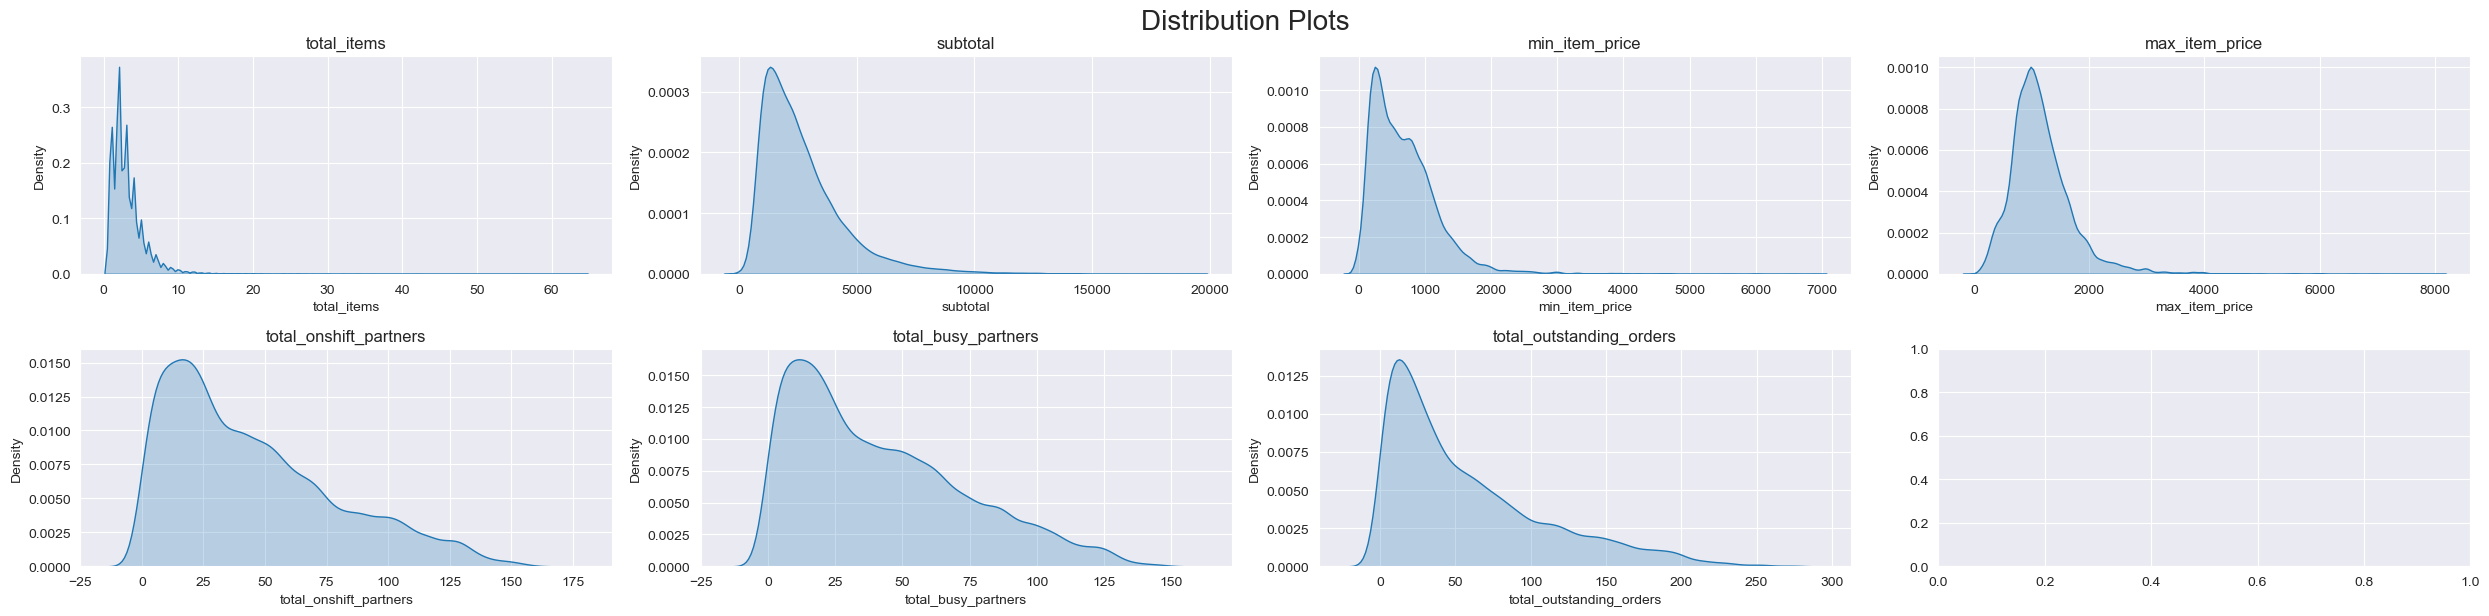

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# sns.set_palette("Set2")
sns.set_style('darkgrid')
# plt.style.use('dark_background')

pandas_df = df.dropna().sample(False,fraction = 0.25,seed=42).toPandas()

nrows = (len(continuous_cols) // 4) + (len(continuous_cols) % 2)

fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(25, 3 * nrows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each continuous column to create distribution plots
for i, feature in enumerate(continuous_cols):
    sns.kdeplot(data=pandas_df, x=feature, fill=True, ax=axes[i] )
    axes[i].set_title(feature)

# Adjust layout
plt.tight_layout()
plt.suptitle("Distribution Plots", y=1.02, fontsize=20)
plt.show()

**Observe**
- All the distribution seems to be a part od **Log Normal** Distribution (We need to handle negative values since Log Normal can never have value less than 0 or 0).
- `total_items` is highly skewed indicating large presence of outliers.

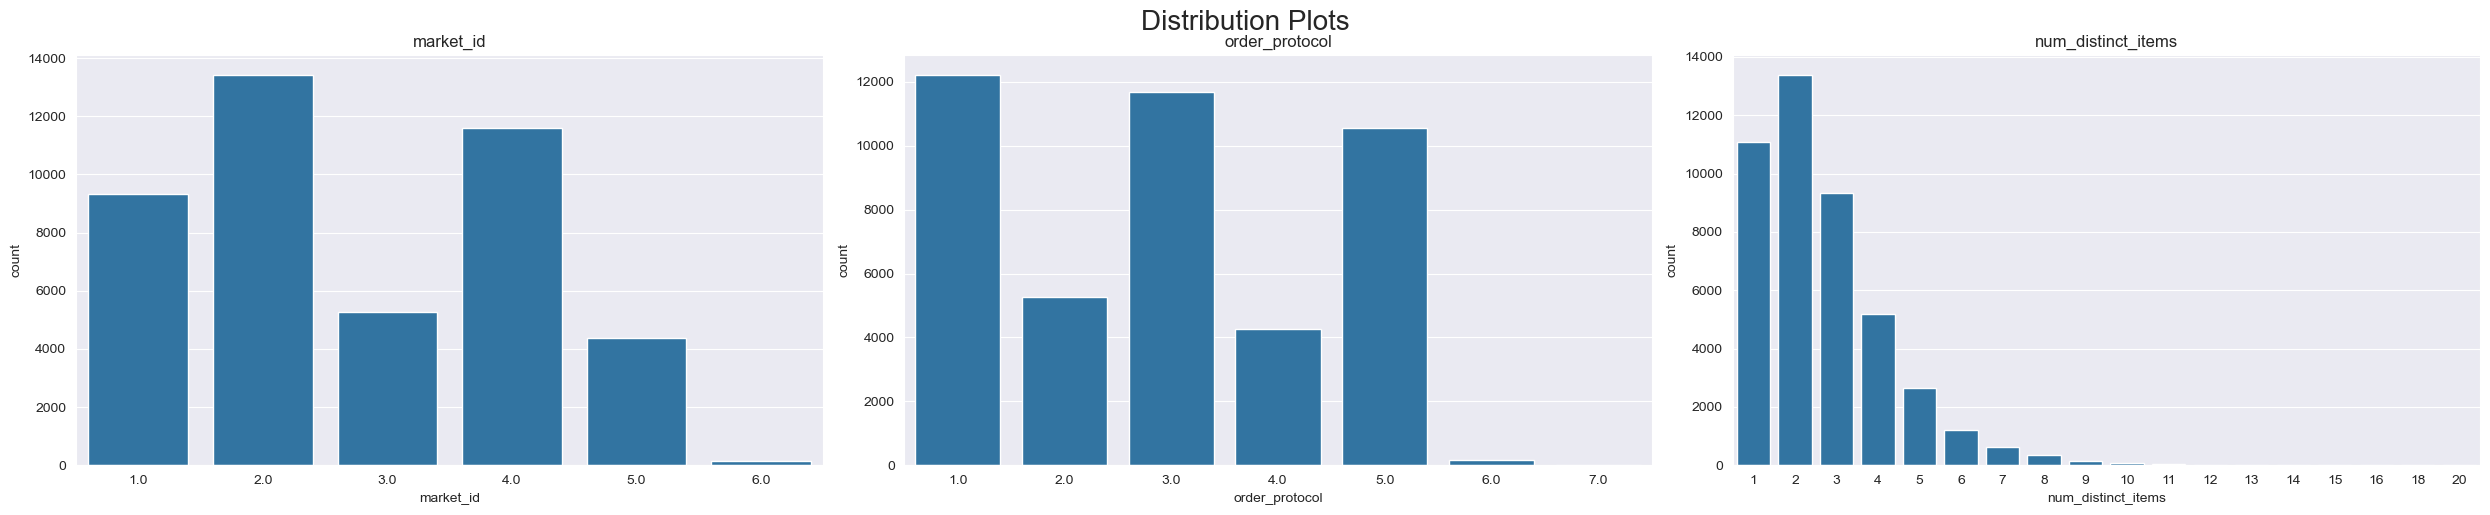

In [17]:
# Analyzing Categorical Columns

nrows = 1

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(25, 5 * nrows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Counter for axes fixing
counter = 0

# Loop through each continuous column to create distribution plots
for i, feature in enumerate(categorical_cols):
    if feature == 'store_id' or feature == 'store_primary_category': 
        counter += 1
        continue
    sns.countplot(data=pandas_df, x=feature, ax=axes[i-counter] )
    axes[i-counter].set_title(feature)

# Adjust layout
plt.tight_layout()

plt.suptitle("Distribution Plots", y=1.02, fontsize=20)
plt.show()

**Observe**
- Customers prefer to at least order two distinct items.

In [18]:
# Creating target variable for further analysis

from pyspark.sql.functions import col,round

df = df.withColumn("eta", round((col("actual_delivery_time").cast("long") - col("created_at").cast("long"))/60))
df.limit(3)

market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,eta
1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,63.0
2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.0
3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NULL,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,30.0


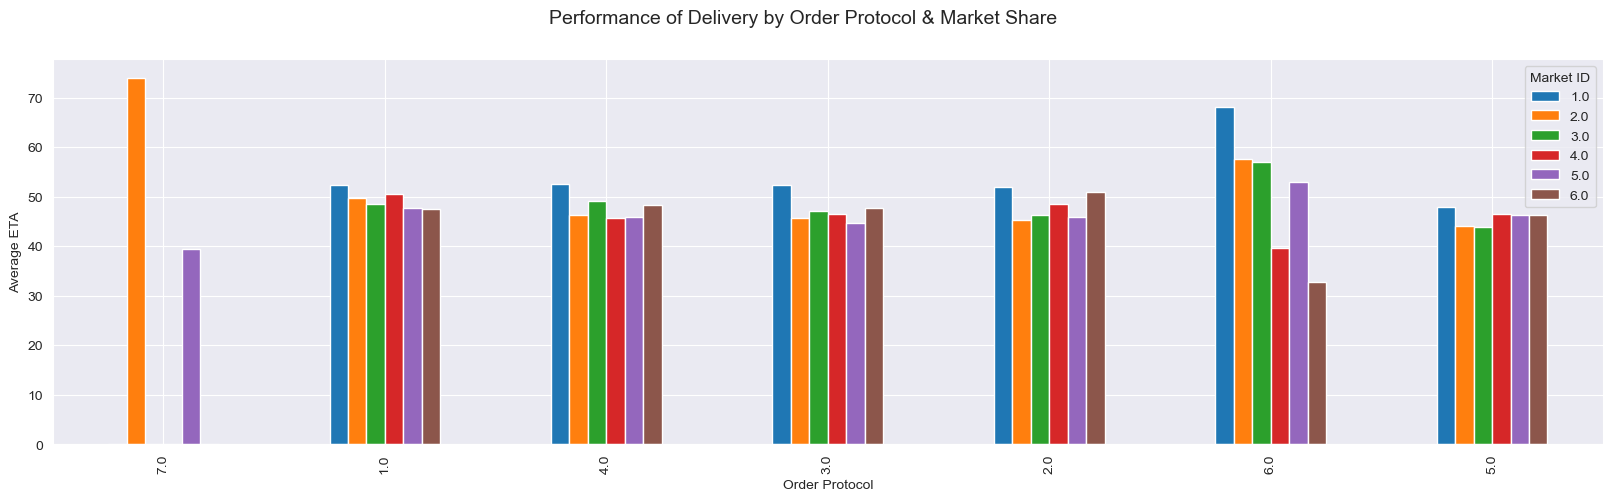

In [19]:
# ----Does the performance of delivery depends on order_protocol and market_id?----
from pyspark.sql.functions import avg

pandas_df = df.dropna()

grouped_df = pandas_df.groupby("order_protocol", "market_id").agg(avg("eta").alias("avg_eta"))
pivot_df = grouped_df.groupby("order_protocol").pivot("market_id").avg("avg_eta").fillna(0).toPandas().set_index("order_protocol")

pivot_df.plot(kind = "bar", stacked=False, figsize = (20,5))
plt.suptitle("Performance of Delivery by Order Protocol & Market Share", fontsize=14)
plt.xlabel('Order Protocol')
plt.ylabel('Average ETA')
plt.legend(title='Market ID')
plt.show()

**Observe**
- In Order Protocol 7, Not all market_id participates and order from market_id 2 takes most time to deliver.
- Order Protocol 6 is delivered fastest from market_id 6 and slowest from market_id 1

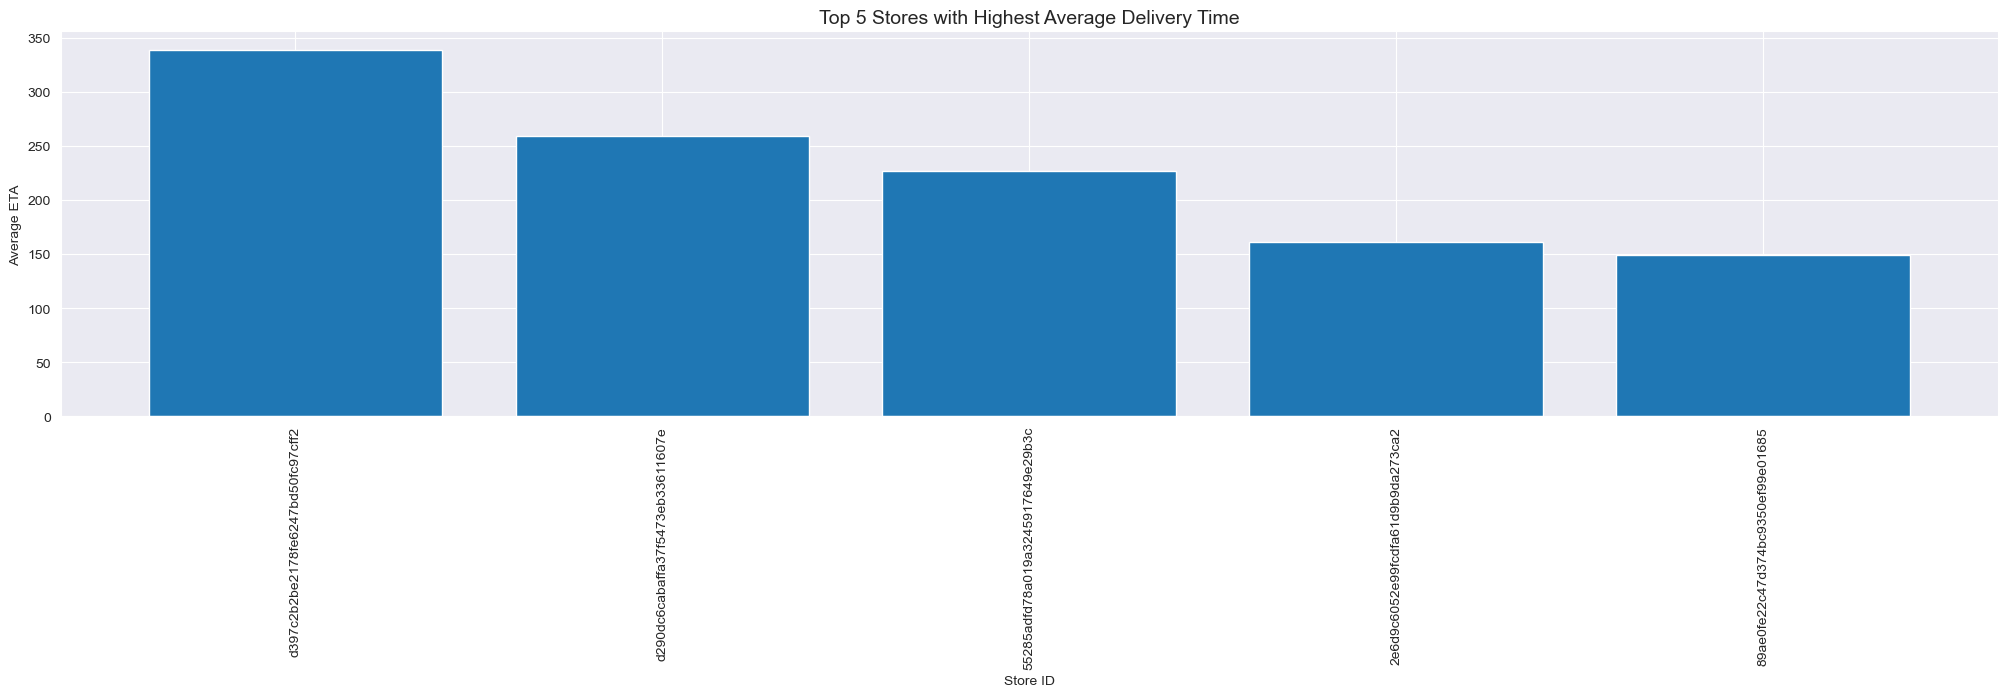

In [20]:
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt

# Drop rows with null values
pandas_df = df.dropna()

# Group by store_id and calculate the average ETA
grouped_df = pandas_df.groupBy("store_id").agg(avg("eta").alias("avg_eta"))

# Convert the result to Pandas DataFrame for plotting
pandas_df = grouped_df.toPandas()

# Sort by average ETA and select the top 6
top_5_stores = pandas_df.sort_values(by='avg_eta', ascending=False).head(5)

# Plot the results
plt.figure(figsize=(25, 5))
plt.bar(top_5_stores['store_id'], top_5_stores['avg_eta'])
plt.title("Top 5 Stores with Highest Average Delivery Time", fontsize=14)
plt.xlabel('Store ID')
plt.ylabel('Average ETA')
plt.xticks(rotation=90)  # Rotate x-axis labels if necessary for better readability
plt.show()


**Observe**

- A very high `eta` of 300 minutes is observed for some stores.
- Needs further inspection.

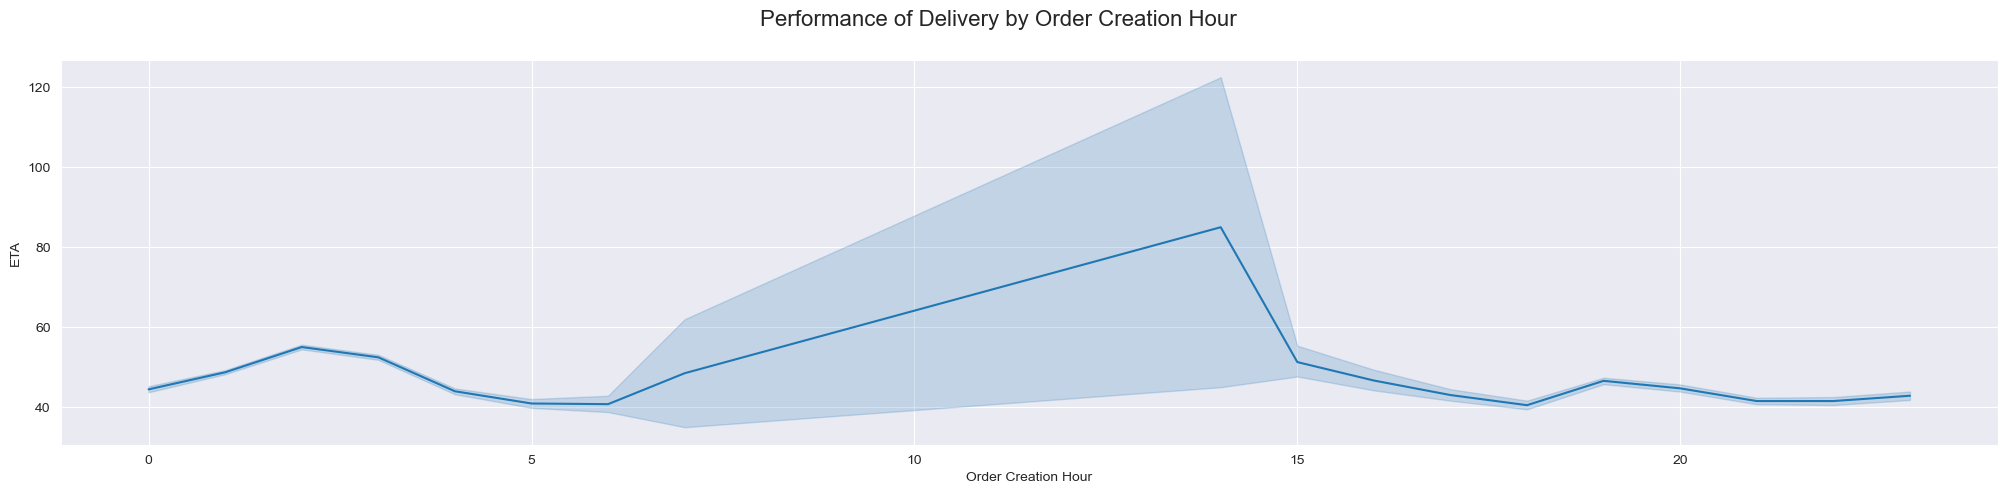

In [21]:
#----Effect of hour on ETA----

from pyspark.sql.functions import hour,col

# Extract hour column from created at
df = df.withColumn("hour", hour(col('created_at')))

pandas_df = df.dropna().sample(False,0.15,seed=42).toPandas()

plt.figure(figsize=(25,5))
sns.lineplot(x=pandas_df["hour"],y=pandas_df["eta"])
plt.suptitle("Performance of Delivery by Order Creation Hour", fontsize=16)
plt.xlabel('Order Creation Hour')
plt.ylabel('ETA')
plt.show()   

**Observe**
- Order takes more eta to deliver when it is placed during afternoon.

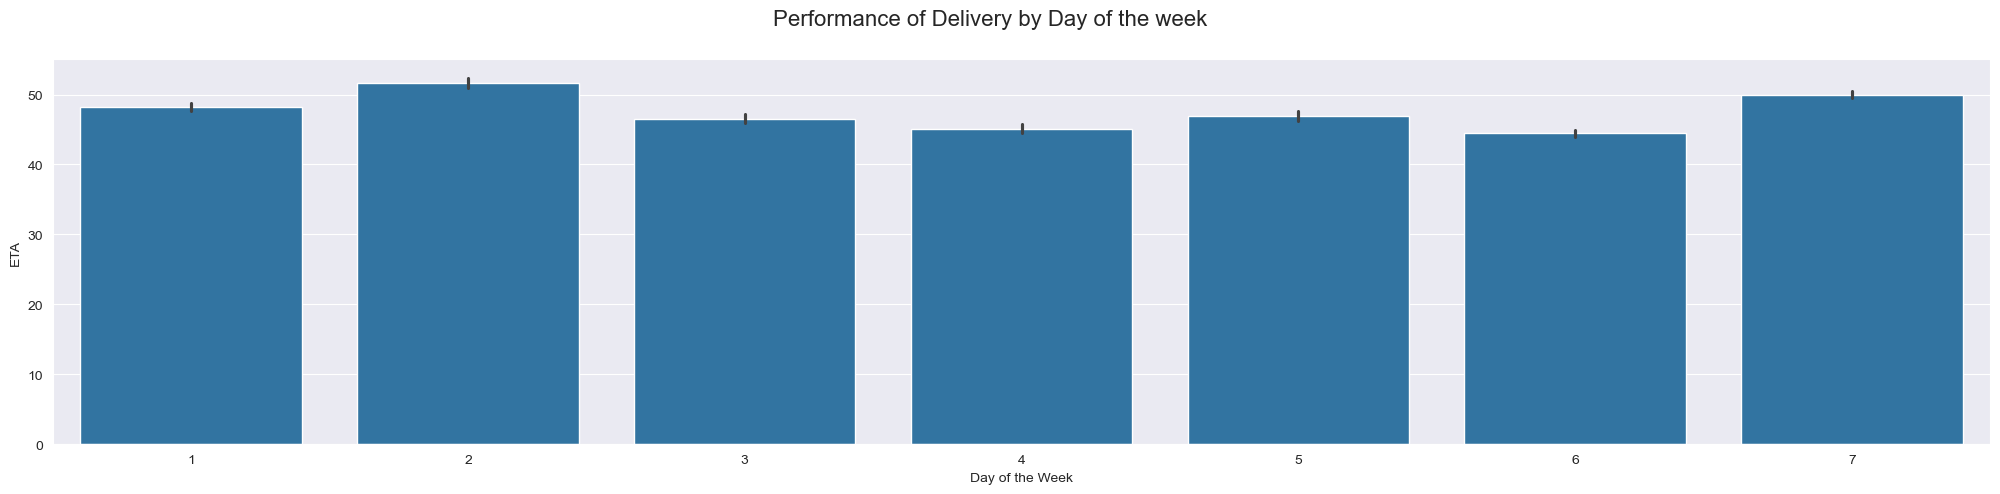

In [22]:
#----Effect of weekday on ETA----

from pyspark.sql.functions import dayofweek

# Extract hour column from created at
df = df.withColumn("day_of_week", dayofweek(col('created_at')))

pandas_df = df.dropna().sample(False,0.15,seed=42).toPandas()

plt.figure(figsize=(25,5))
sns.barplot(x=pandas_df["day_of_week"],y=pandas_df["eta"])
plt.suptitle("Performance of Delivery by Day of the week", fontsize=16)
plt.xlabel('Day of the Week')
plt.ylabel('ETA')
plt.show()   


In [23]:
# Appending New Feature to respective columns
categorical_cols.append('day_of_week')
categorical_cols.append('hour')
target_var = 'eta'

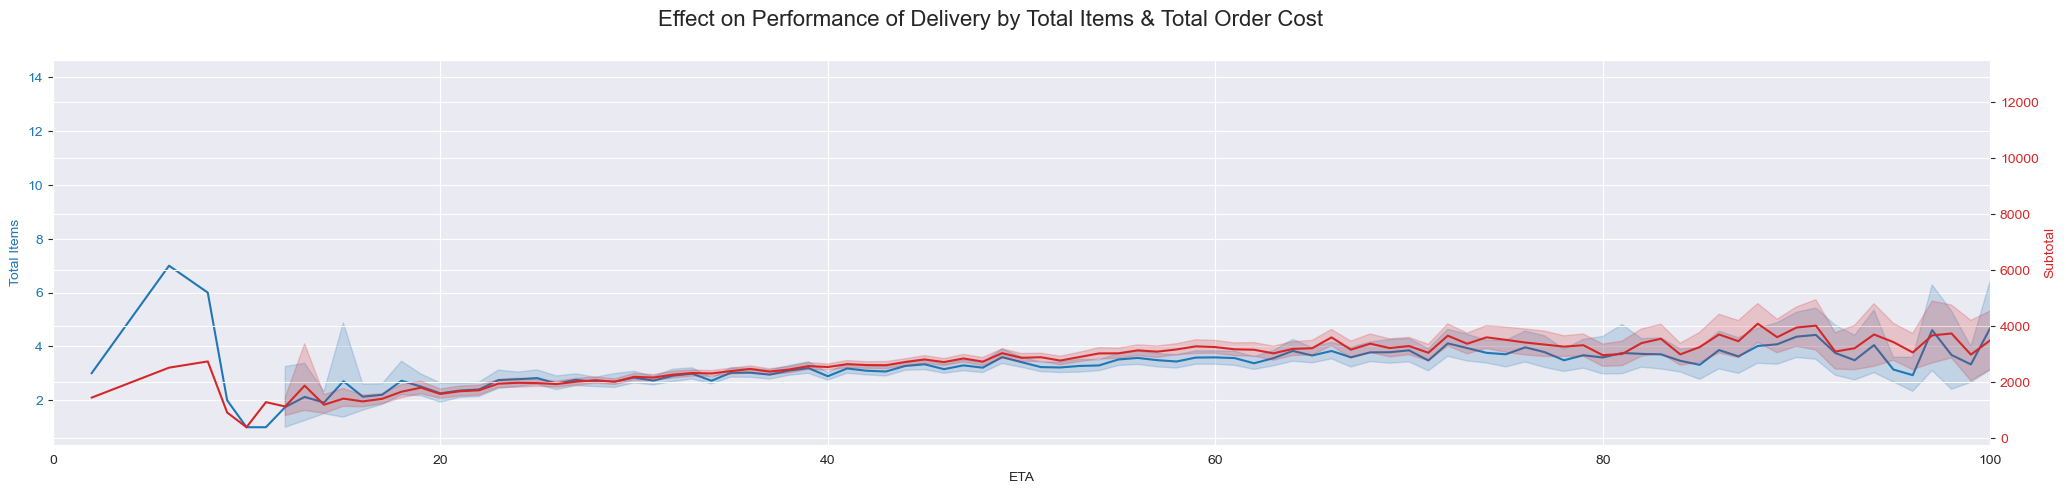

In [24]:
###----Effect on Performance of Delivery by Total Items & Total Order Cost---

fig, ax1 = plt.subplots(figsize=(25, 5))

# Plot total_items on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('ETA')
ax1.set_ylabel('Total Items', color=color)
sns.lineplot(x=pandas_df["eta"], y=pandas_df["total_items"], ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Subtotal', color=color)
sns.lineplot(x=pandas_df["eta"], y=pandas_df["subtotal"], ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and show the plot
plt.suptitle("Effect on Performance of Delivery by Total Items & Total Order Cost", fontsize=16)
plt.xlim(0,100)
plt.show()

**Observe**
- No concrete visual pattern observed between Items Order Cost and eta.

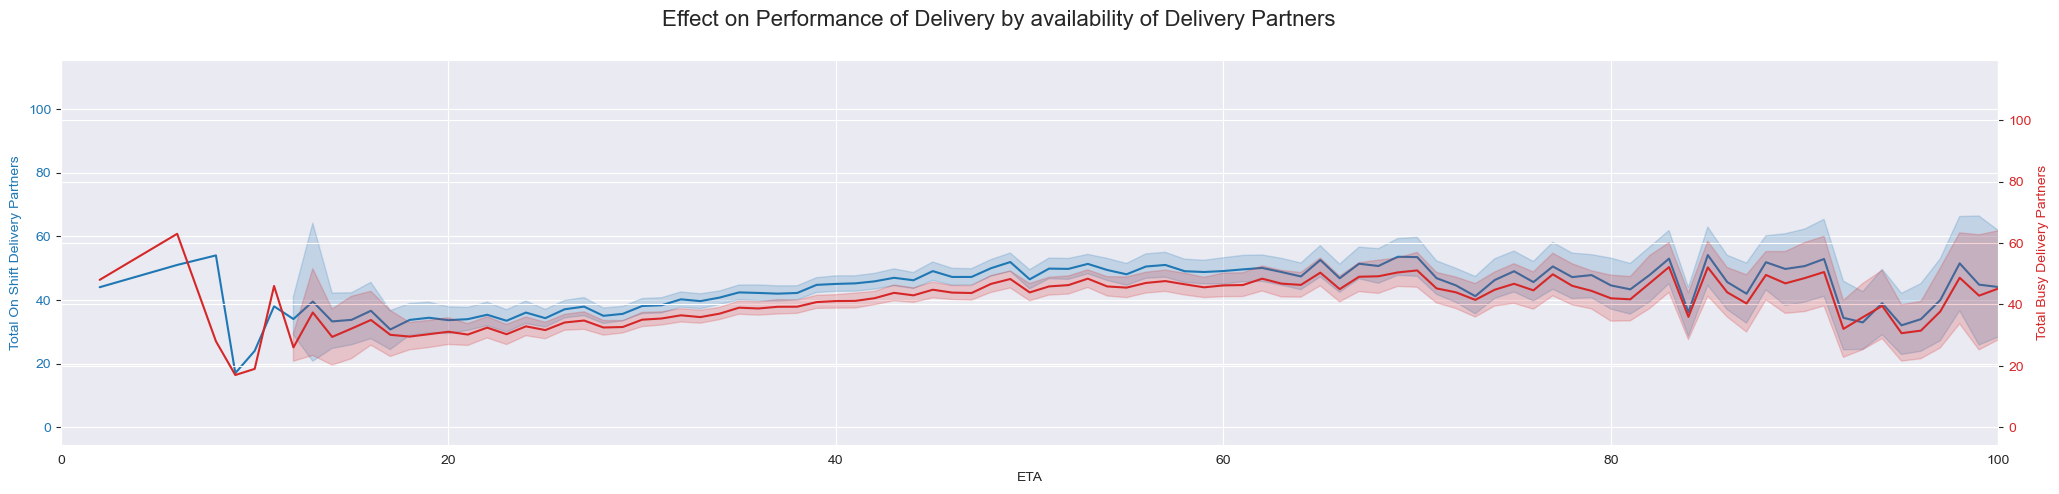

In [25]:
###----Analyze connection between total_onshift_partners 7 total_busy_partners w.r.t to eta---

###----Effect on Performance of Delivery by Total Items & Total Order Cost---

fig, ax1 = plt.subplots(figsize=(25, 5))

# Plot total_items on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('ETA')
ax1.set_ylabel('Total On Shift Delivery Partners', color=color)
sns.lineplot(x=pandas_df["eta"], y=pandas_df["total_onshift_partners"], ax=ax1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Busy Delivery Partners', color=color)
sns.lineplot(x=pandas_df["eta"], y=pandas_df["total_busy_partners"], ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and show the plot
plt.suptitle("Effect on Performance of Delivery by availability of Delivery Partners", fontsize=16)
plt.xlim(0,100)
plt.show()

**Observe**
- No concrete information could be gathered from the visuals.

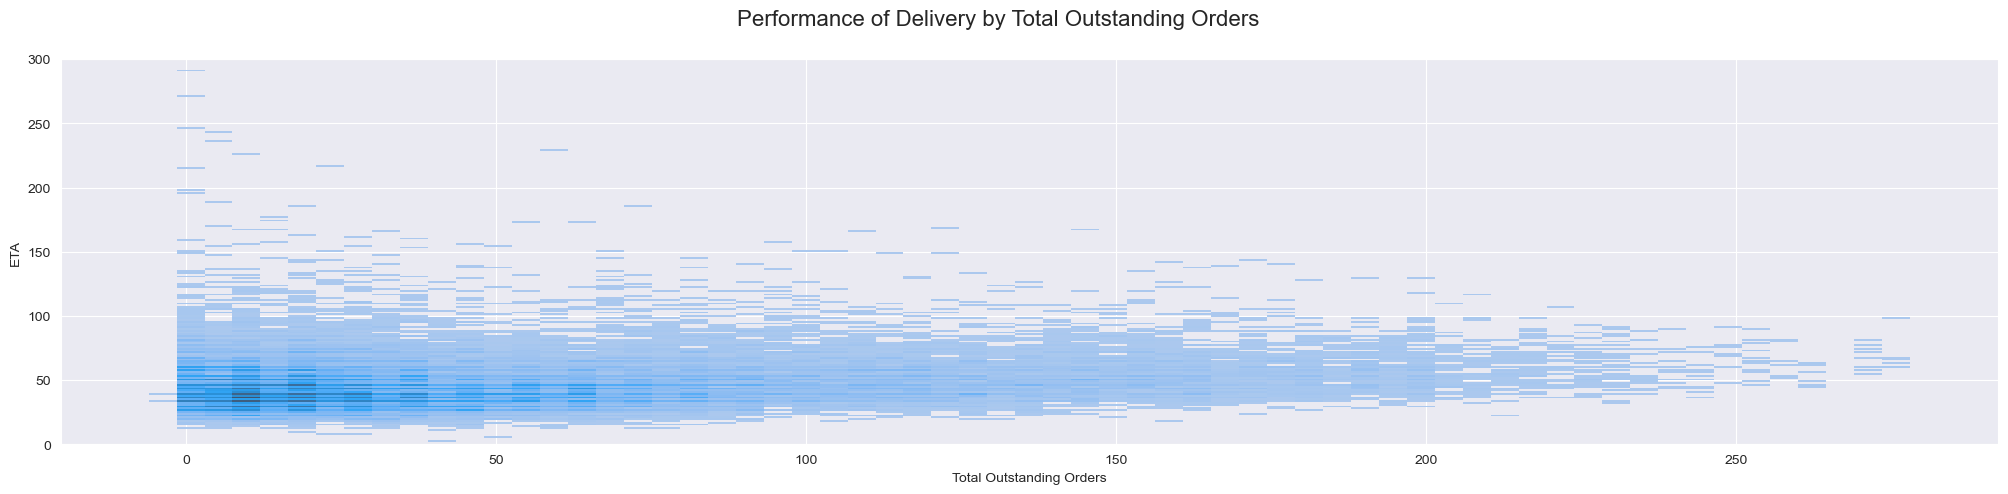

In [26]:
#---Total Outstanding Orders and Eta---
plt.figure(figsize=(25,5))
sns.histplot(data=pandas_df, x='total_outstanding_orders', y = 'eta')
plt.ylim(0,300)
plt.suptitle("Performance of Delivery by Total Outstanding Orders", fontsize=16)
plt.xlabel('Total Outstanding Orders')
plt.ylabel('ETA')
plt.show()  

**Observe**
- Slight pattern observed, where as the pending orders increase the eta also increases.

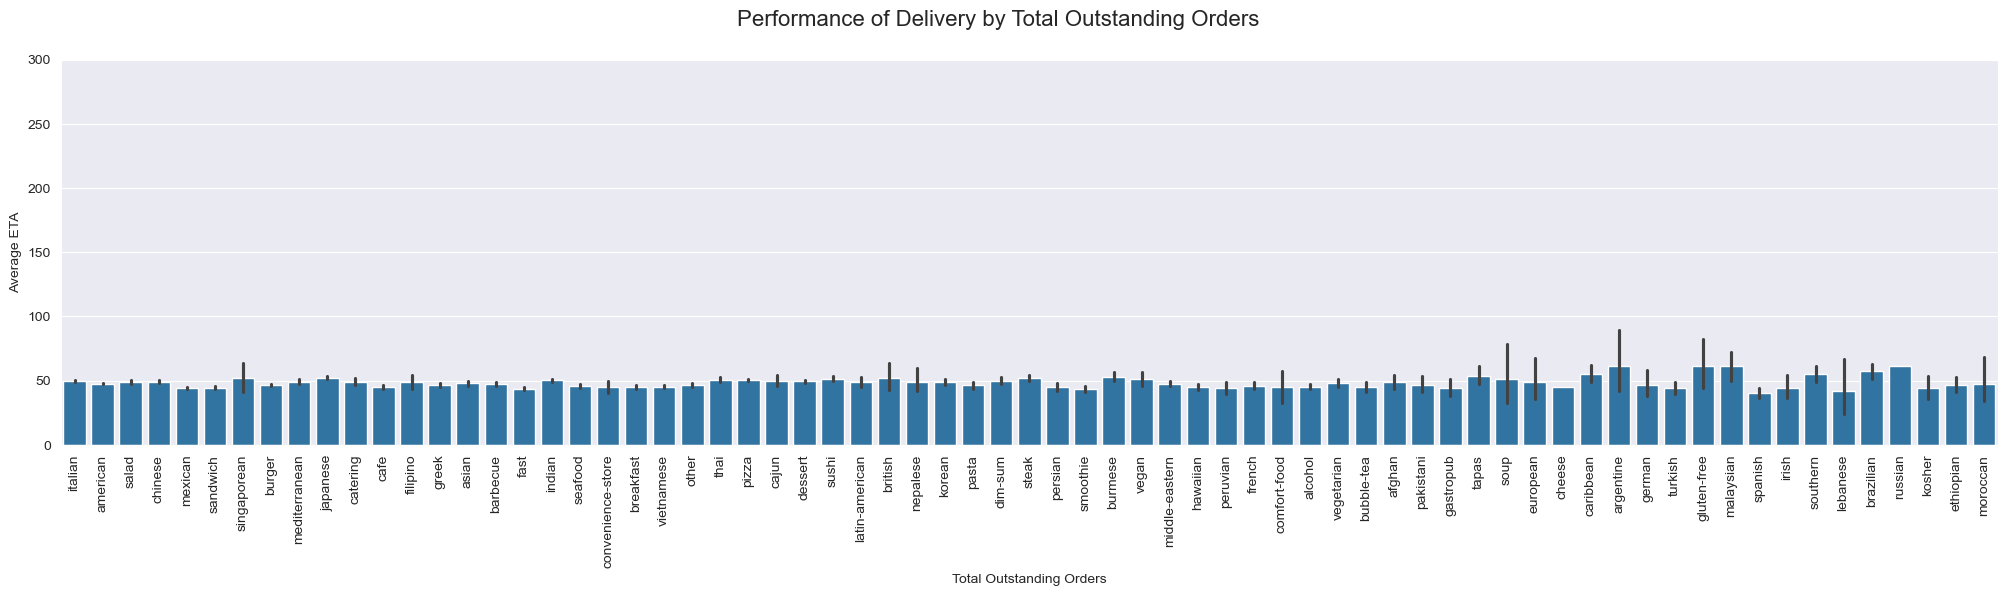

In [27]:
#---Analysis between ETA and Store Primary Category---
plt.figure(figsize=(25,5))
sns.barplot(data=pandas_df, x='store_primary_category', y = 'eta')
plt.ylim(0,300)
plt.suptitle("Performance of Delivery by Total Outstanding Orders", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('Total Outstanding Orders')
plt.ylabel('Average ETA')
plt.show()  

**Observe**
- Comfort Food generally takes more time to deliver.

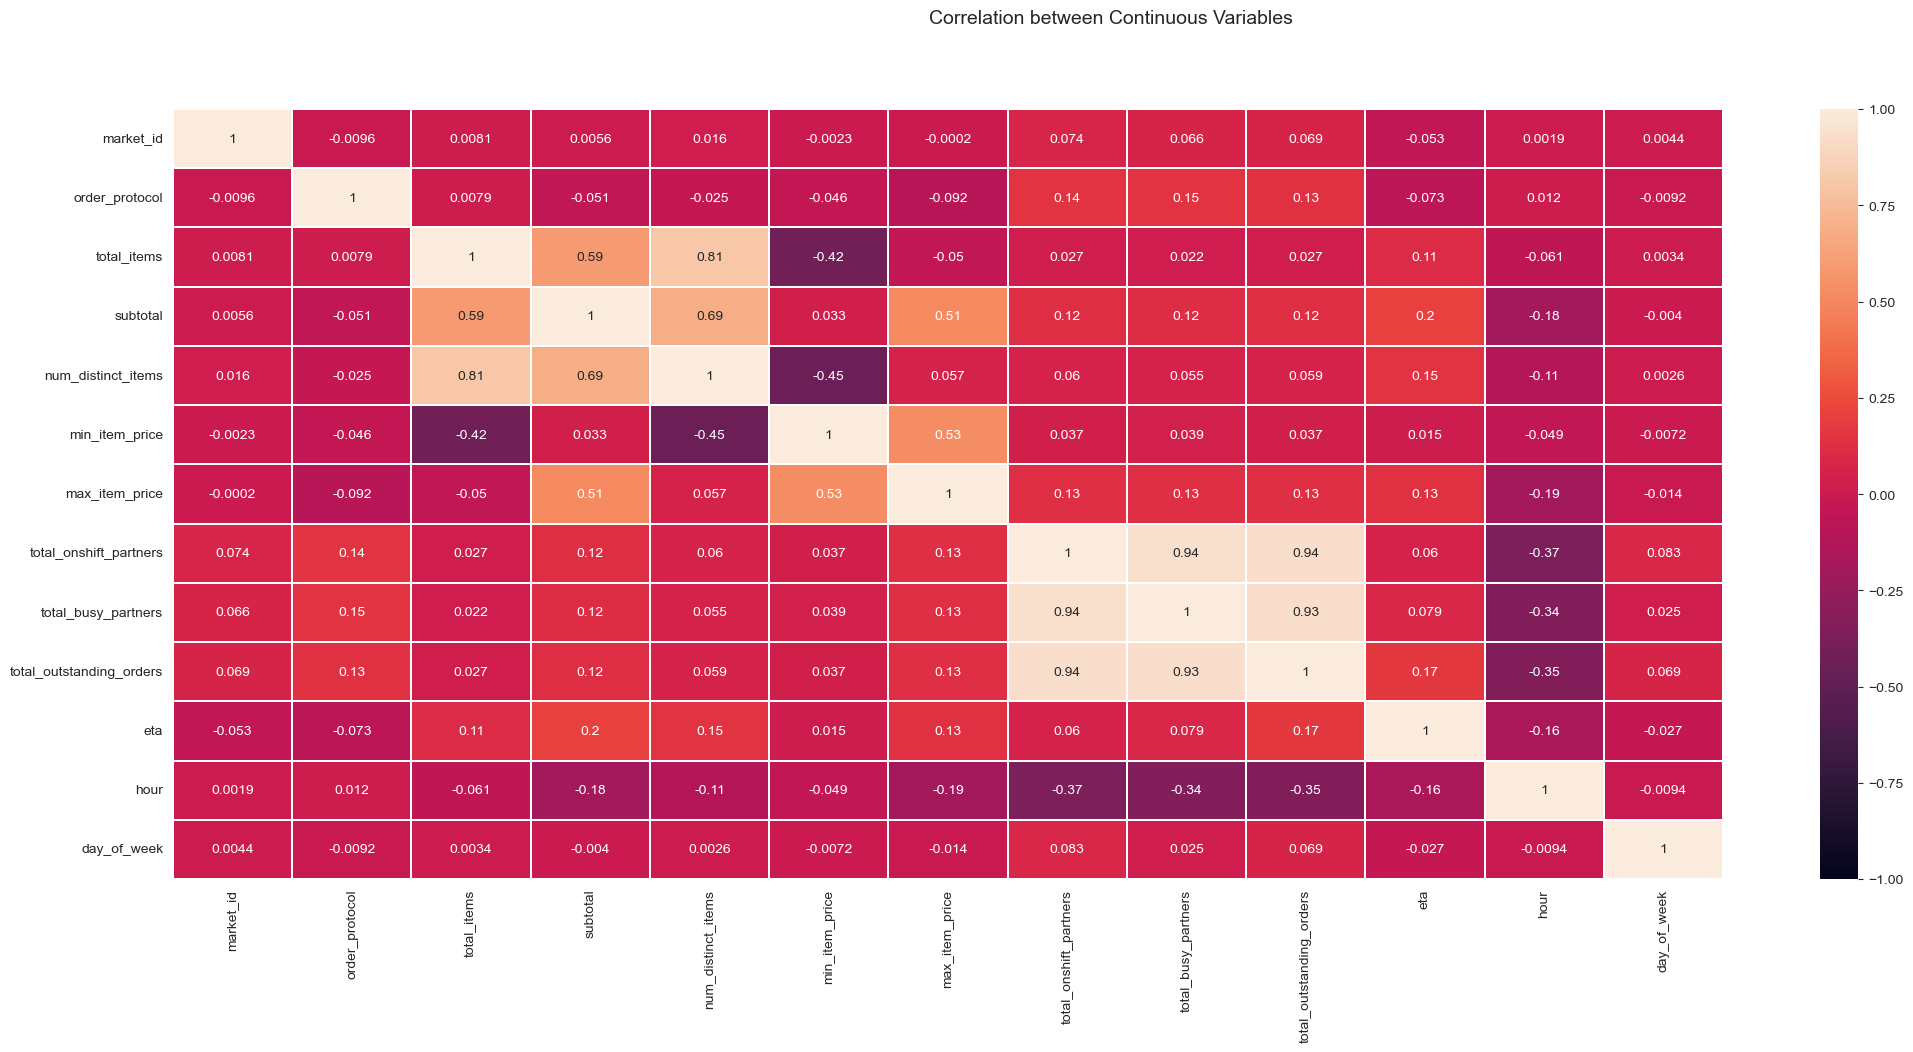

In [28]:
#---Verify Correlation Between Continuous Cols---
plt.figure(figsize=(25,10))
sns.heatmap(pandas_df.corr(numeric_only=True),annot=True,linewidths='0.01', vmin=-1,vmax=1)
plt.suptitle("Correlation between Continuous Variables", fontsize=14)
plt.show()  

**Observe**
- Total Items, Subtotal and Number of Distinct Items are Highly Correlated.
- Partners and Outstanding Orders also show Very High Correlation.
- Minimum Item Price shows negative Correlation with total_items and Num of Distinct Items.

In [29]:
#---Outlier Analysis---

import numpy as np

def iqr_outlier_detection(df, columns):
    bounds = {}
    for col_name in columns:
        quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
        Q1, Q3 = quantiles[0], quantiles[1]
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        bounds[col_name] = (lower_bound, upper_bound)
    
    outlier_counts = {}
    total_counts = df.count()
    
    for col_name in columns:
        lower_bound, upper_bound = bounds[col_name]
        outliers = df.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound))
        
        outlier_count = outliers.count()
        outlier_percentage = np.round( (outlier_count / total_counts) * 100,2)
        
        outlier_counts[col_name] = outlier_percentage
    
    return outlier_counts

iqr_outlier_detection(df,continuous_cols)

{'total_items': 4.86,
 'subtotal': 5.84,
 'min_item_price': 3.25,
 'max_item_price': 4.77,
 'total_onshift_partners': 2.16,
 'total_busy_partners': 1.46,
 'total_outstanding_orders': 4.66}

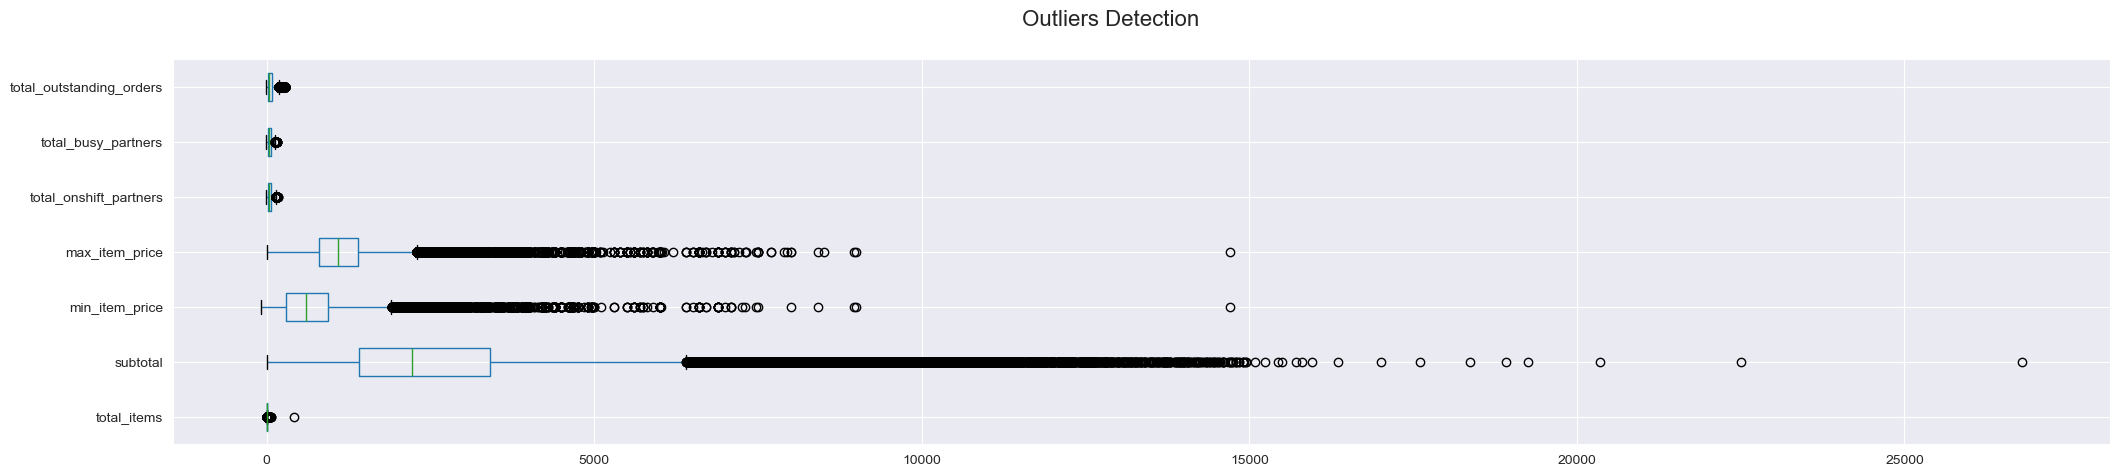

In [30]:
# Plotting Boxplot
df.select(*continuous_cols).dropna().toPandas().boxplot(vert=False,figsize=(25,5))
plt.suptitle("Outliers Detection", fontsize = 16)
plt.show()


**Observe**
- Outliers observed in total_items, max_item_price and subtotal most.

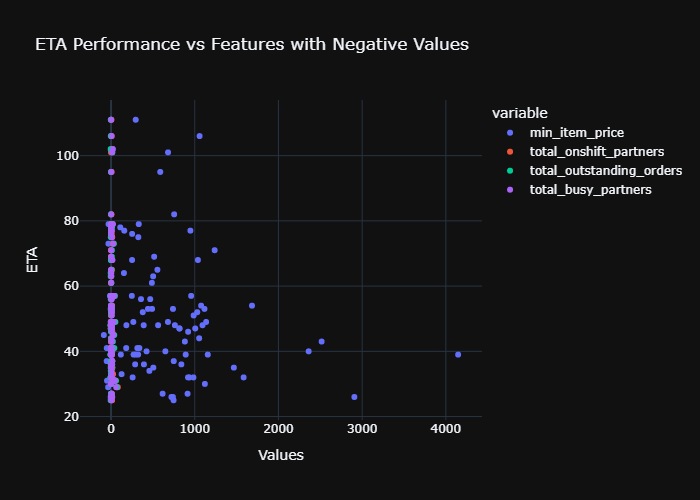

In [31]:
from pyspark.sql.functions import col
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "jupyterlab+png"

negative_cols = ['min_item_price','total_onshift_partners','total_outstanding_orders','total_busy_partners']
negative_pd_df = df.filter( (col('min_item_price')<0) | (col('total_onshift_partners')<0)  | (col('total_outstanding_orders')<0) 
          | (col('total_busy_partners')<0)  ).select(*negative_cols+['eta']).dropna().toPandas()

melted_df = negative_pd_df.melt(id_vars=['eta'], value_vars=negative_cols, var_name='variable', value_name='value')

fig = px.scatter(melted_df, x='value', y='eta',color='variable',title='ETA Performance vs Features with Negative Values')
fig.update_layout(xaxis_title='Values', yaxis_title='ETA')
fig.show()

**Observe**
- Negative Values could indicate, refund ore free product in min item price.
- Negative values in other could denote a state where delivery personals are available in excess or less indicating either. 

# Data Preprocessing

#### **Data Imputation**

In [32]:
# Dropping all those rows where we dont know actual delivery time.
df_filtered = df.dropna(subset=['actual_delivery_time'])
df_filtered.limit(5)

# Dropping where both market_id and store_primary_category is null
df_filtered = df_filtered.filter(~(df.market_id.isNull() & df.store_primary_category.isNull()))

In [33]:
# Imputing Store Primary Category with Mode of Market ID
from pyspark.sql import functions as F
from pyspark.sql.window import Window


df_filtered = df_filtered.fillna({"market_id": -1})

most_frequent_category = df_filtered.groupBy("market_id", "store_primary_category") \
    .count() \
    .withColumn("rank", F.row_number().over(Window.partitionBy("market_id").orderBy(F.desc("count")))) \
    .filter("rank = 1") \
    .select("market_id", "store_primary_category")

most_frequent_category = most_frequent_category.withColumnRenamed("store_primary_category", "most_frequent_category")
most_frequent_category.limit(5)

market_id,most_frequent_category
-1.0,american
1.0,american
2.0,mexican
3.0,american
4.0,pizza


In [34]:
df_filtered = df_filtered.join(most_frequent_category, on=["market_id"], how="left").withColumn(
    "store_primary_category",
    F.coalesce(df["store_primary_category"], most_frequent_category["most_frequent_category"])
).drop(most_frequent_category["most_frequent_category"])

df_filtered.limit(5)

market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,eta,hour,day_of_week
1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,63.0,22,6
2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.0,21,3
3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,american,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,30.0,20,5
3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,american,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.0,21,3
3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,american,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,40.0,2,1


In [35]:
df_filtered = df_filtered.withColumn("market_id", F.when(df_filtered["market_id"] == -1, None).otherwise(df_filtered["market_id"]))

In [36]:
# Imputing Continuous Columns

from sklearn.impute import KNNImputer

pandas_df = df_filtered.toPandas()

imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(pandas_df[continuous_cols +["market_id","order_protocol"]])    

# >>> could have also used Dask KNNImputer, since it supports parallelization

In [37]:
non_null_cat = [
    'store_id',
    'store_primary_category',
    'num_distinct_items',
    'day_of_week',
    'hour'
]

imputed_df = pd.DataFrame(imputed_array, columns=continuous_cols + ["market_id","order_protocol"])
concat_df = pd.concat([pandas_df[[target_var] + temporal_cols + non_null_cat], imputed_df], axis=1)

# Convert the imputed DataFrame back to Spark DataFrame
df_imputed = spark.createDataFrame(concat_df)

# Add an index column to original and imputed DataFrame to join them back
df.limit(5)

market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,eta,hour,day_of_week
1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,63.0,22,6
2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,67.0,21,3
3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NULL,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,30.0,20,5
3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NULL,1.0,6,6900,5,600,1800,1.0,1.0,2.0,51.0,21,3
3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NULL,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,40.0,2,1


In [38]:
# Verifying Total NaN's
concat_df.isna().sum()

eta                         0
created_at                  0
actual_delivery_time        0
store_id                    0
store_primary_category      0
num_distinct_items          0
day_of_week                 0
hour                        0
total_items                 0
subtotal                    0
min_item_price              0
max_item_price              0
total_onshift_partners      0
total_busy_partners         0
total_outstanding_orders    0
market_id                   0
order_protocol              0
dtype: int64

In [39]:
# Saving File
concat_df.to_csv("../data/clean/imputed.csv", index=False)

#### **Encoding Dataset**

In [40]:
df_imputed = spark.read.csv("../data/clean/imputed.csv", header=True, inferSchema=True)

**Explanation**
- Only need to encode `store_id` and `store_primary_category`
- For both we are going to use target encoding

In [41]:
# Target Encoding

# Calculate means with respect to the target
store_id_mean = df_imputed.groupBy('store_id').agg(F.mean(target_var).alias('store_id_mean_target'))
store_primary_category_mean = df_imputed.groupBy('store_primary_category').agg(F.mean(target_var).alias('store_primary_category_mean_target'))

df_imputed = df_imputed.join(store_id_mean, on='store_id', how='left')
df_imputed = df_imputed.join(store_primary_category_mean, on='store_primary_category', how='left')

# Replace original columns with the mean-encoded values
df_imputed = df_imputed.withColumnRenamed('store_id', 'original_store_id') \
                       .withColumnRenamed('store_primary_category', 'original_store_primary_category') \
                       .withColumnRenamed('store_id_mean_target', 'store_id') \
                       .withColumnRenamed('store_primary_category_mean_target', 'store_primary_category')


# Drop unwanted columns
columns_to_drop = ['actual_delivery_time', 'created_at', 'original_store_id', 'original_store_primary_category']
df_imputed = df_imputed.drop(*columns_to_drop)

#### **Handling Negative Values**

In [42]:
from pyspark.sql.functions import col

neg_cols= ['min_item_price', 'total_onshift_partners', 'total_outstanding_orders', 'total_busy_partners']
for column in neg_cols:
    df_imputed = df_imputed.filter(col(column) >= 0)

**Explanation**
- These values can be a typo or might be a scenario where it makes sense in business context. 
- For now, I am treating this as an anomaly and dropping rows with negative columns in these groups, the reason for this behaviour is because destructive in case of Log Transformation and Scaling as well.
- Moreover, Log Norm distributions can't have 0 or negative values.


#### **Handling Log Normal Disbs**

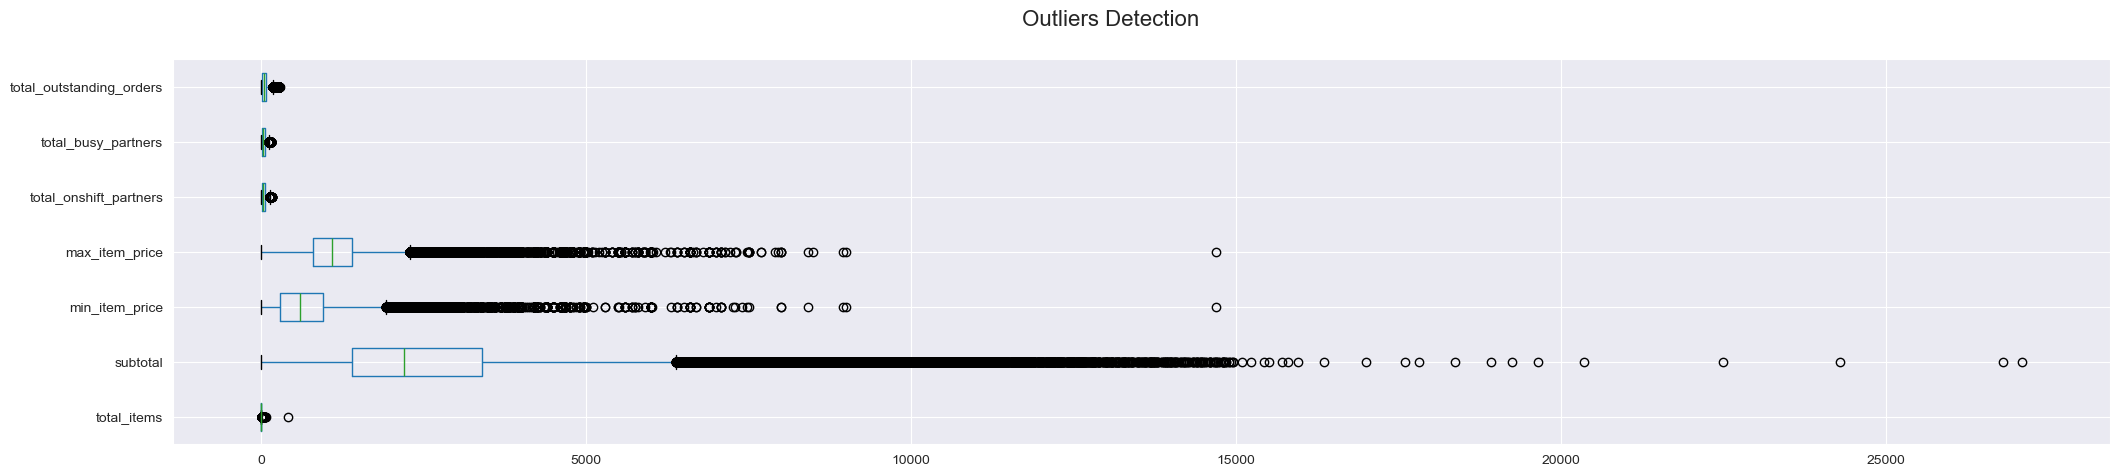

In [43]:
# Plotting Boxplot
df_imputed.select(*continuous_cols).dropna().toPandas().boxplot(vert=False,figsize=(25,5))
plt.suptitle("Outliers Detection", fontsize = 16)
plt.show()


In [44]:
# Reducing the affect of Outliers on log normal distributions
for col in continuous_cols:
        df_imputed = df_imputed.withColumn(col, F.log(F.col(col) + 1e-15))

**Explanation**
- A log normal value can never have negative values, so we are handling it by skipping apply log normal here.

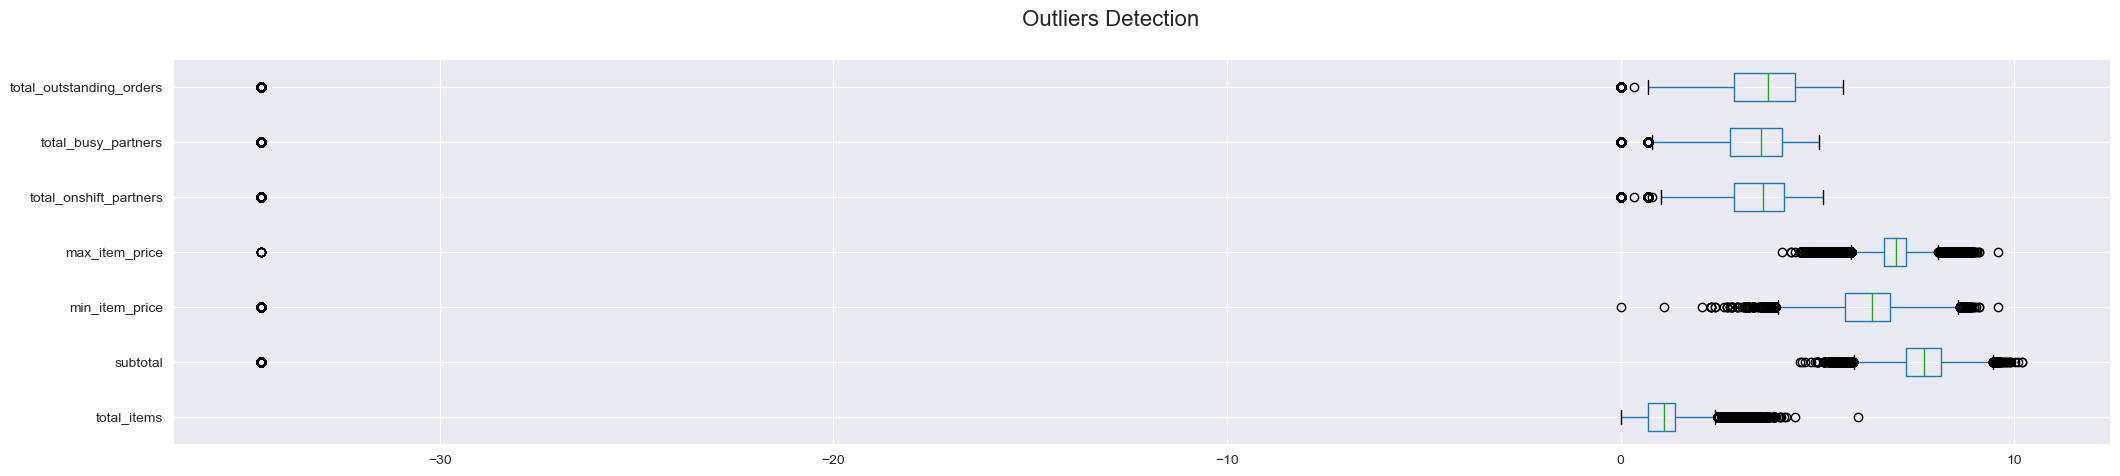

In [45]:
# Plotting Boxplot
df_imputed.select(*continuous_cols).dropna().toPandas().boxplot(vert=False,figsize=(25,5))
plt.suptitle("Outliers Detection", fontsize = 16)
plt.show()

In [46]:
df_imputed.toPandas().to_csv("../data/clean/encoded.csv", index=False)

#### **Outliers Detection using LOF**

In [47]:
df_encoded = pd.read_csv('../data/clean/encoded.csv')
df_encoded.head(5)

,eta,num_distinct_items,day_of_week,hour,total_items,subtotal,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,market_id,order_protocol,store_id,store_primary_category
0,63.0,4,6,22,1.386294e+00,8.143517,6.322565,7.122060,3.496508e+00,2.639057e+00,3.044522,1.0,1.0,63.000000,47.833310
1,67.0,1,3,21,1.110223e-15,7.549609,7.244228,7.244228,1.110223e-15,6.931472e-01,0.693147,2.0,2.0,48.076923,44.721816
2,30.0,1,5,20,1.110223e-15,7.549609,7.549609,7.549609,1.110223e-15,-3.453878e+01,-34.538776,3.0,1.0,48.076923,47.833310
3,51.0,5,3,21,1.791759e+00,8.839277,6.396930,7.495542,1.110223e-15,1.110223e-15,0.693147,3.0,1.0,48.076923,47.833310
4,40.0,3,1,2,1.098612e+00,8.268732,7.003065,7.377759,1.791759e+00,1.791759e+00,2.197225,3.0,1.0,48.076923,47.833310


In [48]:
# Splitting dataset
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=42) # train/test
train_df, val_df = train_test_split(train_df, test_size=0.35, random_state=42) # train/val

In [49]:
# Standardizing and MinMax Scaling on test data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

num_scaler = StandardScaler()
train_df[continuous_cols] = num_scaler.fit_transform(train_df[continuous_cols])

# MinMax Scaling categorical cols
cat_scaler = MinMaxScaler()
train_df[categorical_cols] = cat_scaler.fit_transform(train_df[categorical_cols])

# Scaling on Test & Validation Data
val_df[continuous_cols] = num_scaler.transform(val_df[continuous_cols])
val_df[categorical_cols] = cat_scaler.transform(val_df[categorical_cols])

test_df[continuous_cols] = num_scaler.transform(test_df[continuous_cols])
test_df[categorical_cols] = cat_scaler.transform(test_df[categorical_cols])

In [50]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True)  # Novelty for ability to detect anomalies in Test Data
lof_model = lof.fit(train_df.loc[:,train_df.columns != target_var].values)

**Explanation**
- We'll fit our lof model only on training set, so that our model generalizes instead of trying to learn noise. 

In [51]:
train_outliers = lof.predict(train_df.loc[:,train_df.columns != target_var].values)
val_outliers = lof.predict(val_df.loc[:,val_df.columns != target_var].values)
test_outliers = lof.predict(test_df.loc[:,test_df.columns != target_var].values)


assert len(train_outliers) == len(train_df)
assert len(val_outliers) == len(val_df)
assert len(test_outliers) == len(test_df)

In [52]:
total_outliers_train = sum(train_outliers == -1)
total_outliers_val = sum(val_outliers == -1)
total_outliers_test= sum(test_outliers == -1)

print(f"Train outliers detected: {total_outliers_train}")
print(f"Validation outliers detected: {total_outliers_val}")
print(f"Test outliers detected: {total_outliers_test}")


val_df = val_df[val_outliers == 1]
test_df = test_df[test_outliers == 1]
train_df = train_df[train_outliers == 1]

Train outliers detected: 4490
Validation outliers detected: 2913
Test outliers detected: 2117


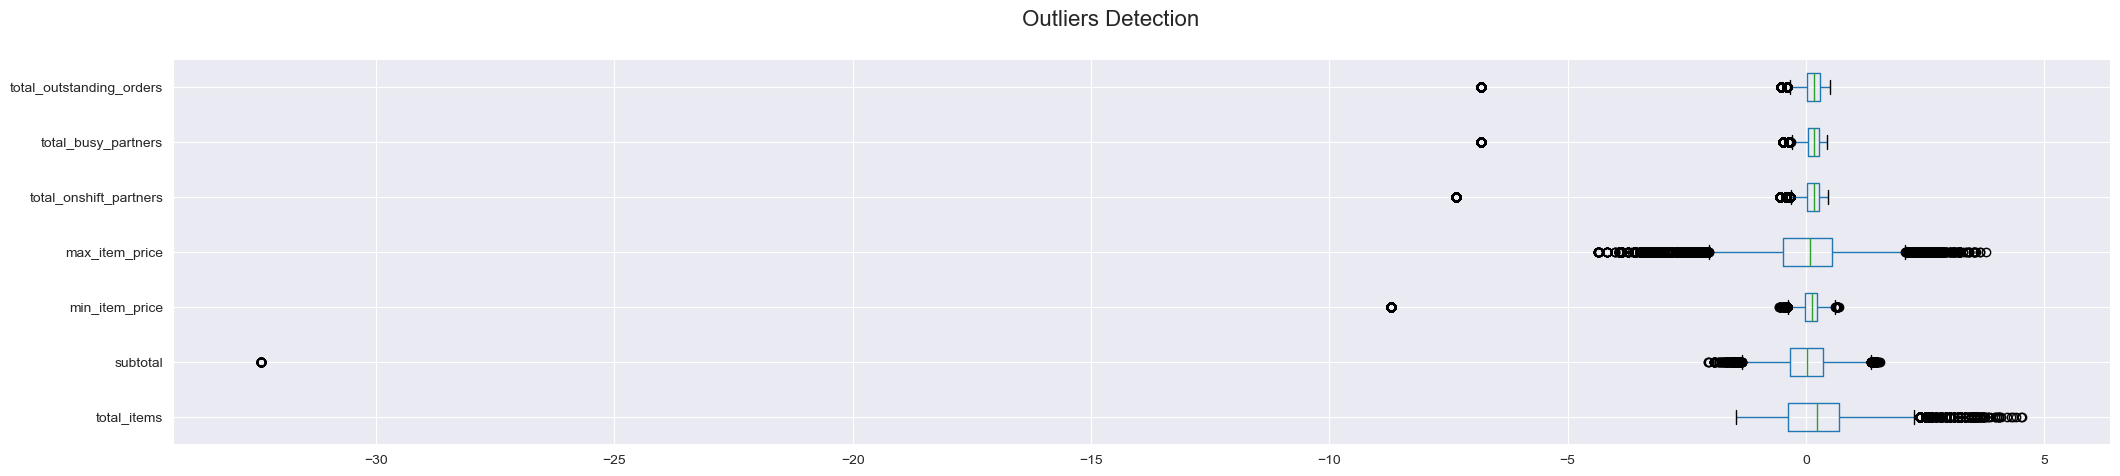

In [53]:
# Plotting Boxplot
train_df[continuous_cols].boxplot(vert=False,figsize=(25,5))
plt.suptitle("Outliers Detection", fontsize = 16)
plt.show()

**Observe**
- LOF works on High Dimensional, we cannot observe its effect properly here.

In [54]:
# Saving data
train_df.to_csv("../data/train/train.csv")
val_df.to_csv("../data/validation/val.csv")
test_df.to_csv("../data/test/test.csv")

# Data Modelling

#### **Simple Model**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('../data/train/train.csv').drop(columns='Unnamed: 0')
val_df = pd.read_csv('../data/validation/val.csv').drop(columns='Unnamed: 0')
test_df = pd.read_csv('../data/test/test.csv').drop(columns='Unnamed: 0')

target_var = 'eta'

X_train = train_df.drop(target_var, axis=1)
y_train = train_df[target_var]
X_val = val_df.drop(target_var, axis=1)
y_val = val_df[target_var]
X_test = test_df.drop(target_var, axis=1)
y_test = test_df[target_var]

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available Computation:",device)

Available Computation: cuda


In [4]:
# Convert dataset for torch tensors since it support parallelization and much more

from torch.utils.data import DataLoader, TensorDataset

batch_size=512
train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Creating Simple Network of Neurons 

import torch
import torch.nn as nn

class SimpleNNModel(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,1)
        )

    def forward(self, x):
        return self.model(x)
    
    # Kernel Initializer 
    def initialize_weights(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.constant_(layer.weight, 0)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

input_dim = X_train.shape[1]
model = SimpleNNModel(input_dim)

print(model)

SimpleNNModel(
  (model): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [6]:
# Training the model

from torch.optim import Adam
from sklearn.metrics import mean_squared_error


# Training function
def train_model(model, train_loader, val_loader, epochs=10, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    train_loss = 0.0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()   # Resets Gradient values to 0
            predictions = model(X_batch).squeeze() # Predict and matches output dimensions
            loss = criterion(predictions, y_batch) 
            loss.backward()
            optimizer.step()  # Update Weights
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch).squeeze()
                val_loss += criterion(predictions, y_batch).item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch+1)%1 ==0:
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')
        
    plt.figure(figsize=(25,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Training and Validation Loss')
    plt.show()
        
    return model

Epoch 1/10, Training Loss: 611.0709881782532, Validation Loss: 1028.9510499542835
Epoch 2/10, Training Loss: 611.9440744146705, Validation Loss: 1035.61549392401
Epoch 3/10, Training Loss: 612.8502704986604, Validation Loss: 1057.1689641615924
Epoch 4/10, Training Loss: 614.5422648054282, Validation Loss: 1028.5469339408126
Epoch 5/10, Training Loss: 612.8719564967386, Validation Loss: 1027.4031135708678
Epoch 6/10, Training Loss: 610.7467662923312, Validation Loss: 1026.9646584005916
Epoch 7/10, Training Loss: 610.8071394026863, Validation Loss: 1028.4386675965552
Epoch 8/10, Training Loss: 610.6899410635547, Validation Loss: 1026.6559196920955
Epoch 9/10, Training Loss: 610.1615855675968, Validation Loss: 1028.7842335420496
Epoch 10/10, Training Loss: 608.3653731085268, Validation Loss: 1042.6319737153894


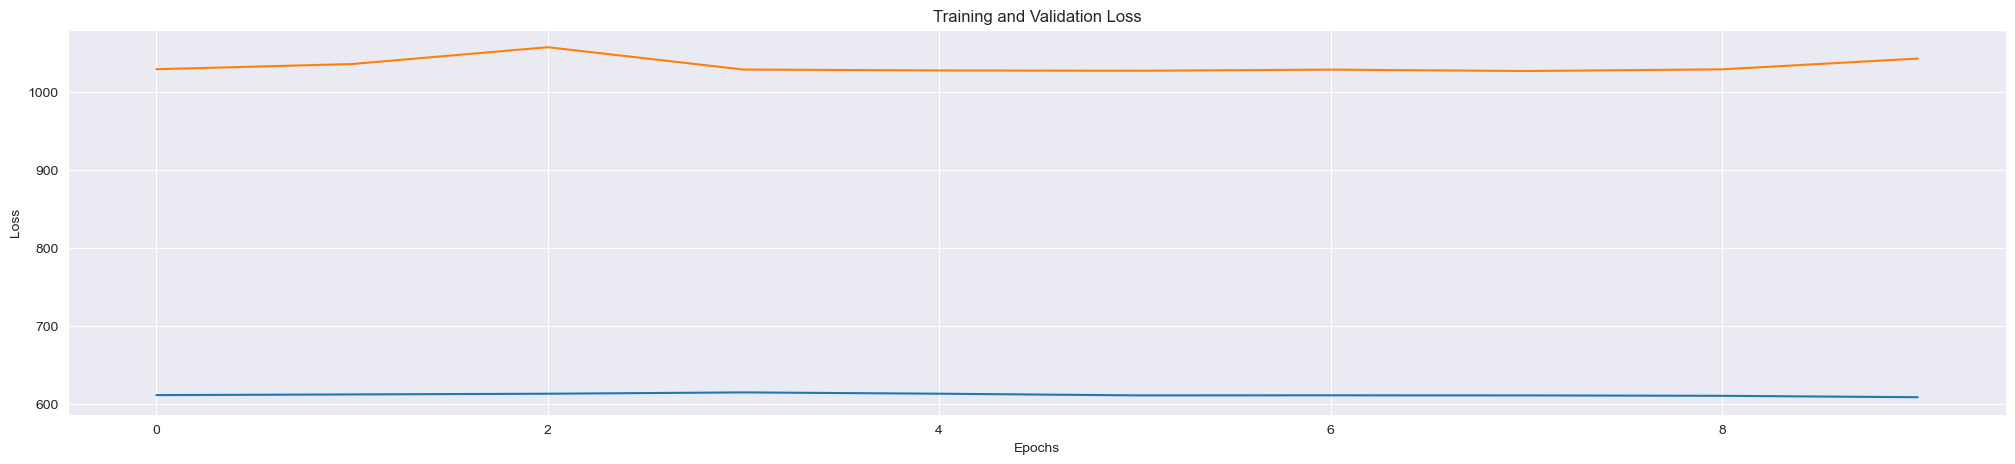

Mean Squared Error on Validation Set: 1042.9715576171875


In [15]:
# Logging Simple Model

import mlflow
import mlflow.pytorch

import logging
import warnings

mlflow.autolog(disable=True)

logging.getLogger("mlflow").setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=UserWarning, module='mlflow')

logging.getLogger("py4j").setLevel(logging.ERROR)
logging.getLogger("mlflow.utils").setLevel(logging.ERROR)

# Suppress specific warnings from mlflow
warnings.filterwarnings("ignore", message="Distutils was imported before Setuptools")
warnings.filterwarnings("ignore", message="Setuptools is replacing distutils")

mlflow.set_tracking_uri("../mlruns/")

mlflow.set_experiment("Simple NN")

with mlflow.start_run():
    model = train_model(model, train_loader, val_loader)
    mlflow.pytorch.log_model(model, "model")
    mlflow.log_param("epochs", 10)
    mlflow.log_param("learning_rate", 0.001),
    mlflow.log_param("batch_size", 512)

    
    # Evaluation on test set
    model.eval()
    with torch.no_grad():
        predictions = model(val_dataset[:][0]).squeeze()
        mse = mean_squared_error(val_dataset[:][1], predictions.numpy())
    
    mlflow.log_metric("test_loss", mse)
    print(f'Mean Squared Error on Validation Set: {mse}')

#### **Complex Model**

In [16]:
import torch.nn as nn

class EnhancedNNModel(nn.Module):
    def __init__(self, input_dim, bn_momentum=0.1, bn_eps=1e-5):
        super(EnhancedNNModel, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32, momentum=bn_momentum, eps=bn_eps),
        )

        self.hidden_layer1 = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64, momentum=bn_momentum, eps=bn_eps),

        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64, momentum=bn_momentum, eps=bn_eps),

        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32, momentum=bn_momentum, eps=bn_eps),

        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32, momentum=bn_momentum, eps=bn_eps),

        )
        self.output_layer = nn.Linear(32, 1)

        self.initialize_weights()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        x = self.hidden_layer3(x)
        x = self.hidden_layer4(x)
        x = self.output_layer(x)
        return x

    def initialize_weights(self):
        for layer in self.children():
            if isinstance(layer, nn.Sequential):
                for sublayer in layer:
                    if isinstance(sublayer, nn.Linear):
                        nn.init.kaiming_uniform_(sublayer.weight, nonlinearity='relu')
                        if sublayer.bias is not None:
                            nn.init.constant_(sublayer.bias, 0)
                    elif isinstance(sublayer, nn.BatchNorm1d):
                        nn.init.constant_(sublayer.weight, 1)
                        nn.init.constant_(sublayer.bias, 0)

input_dim = X_train.shape[1]
model = EnhancedNNModel(input_dim)

print(model)

EnhancedNNModel(
  (input_layer): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (hidden_layer1): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (hidden_layer2): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (hidden_layer3): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (hidden_layer4): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [17]:
# initializing Gradient Clipping as well

def train_model(model, train_loader, val_loader, epochs=50, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for i, (X_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
                    
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch).squeeze()
                val_loss += criterion(predictions, y_batch).item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        if (epoch+1) % 10 == 0: 
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

    plt.figure(figsize=(25,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Training and Validation Loss')
    plt.show()

    return model

Epoch 10/50, Training Loss: 585.3287323315939, Validation Loss: 1023.6722919239718
Epoch 20/50, Training Loss: 576.7758351961771, Validation Loss: 1039.8048598345588
Epoch 30/50, Training Loss: 568.165274699529, Validation Loss: 1025.3784676346124
Epoch 40/50, Training Loss: 562.1940625508627, Validation Loss: 995.7649262372186
Epoch 50/50, Training Loss: 555.6672281424204, Validation Loss: 1001.1803699568206


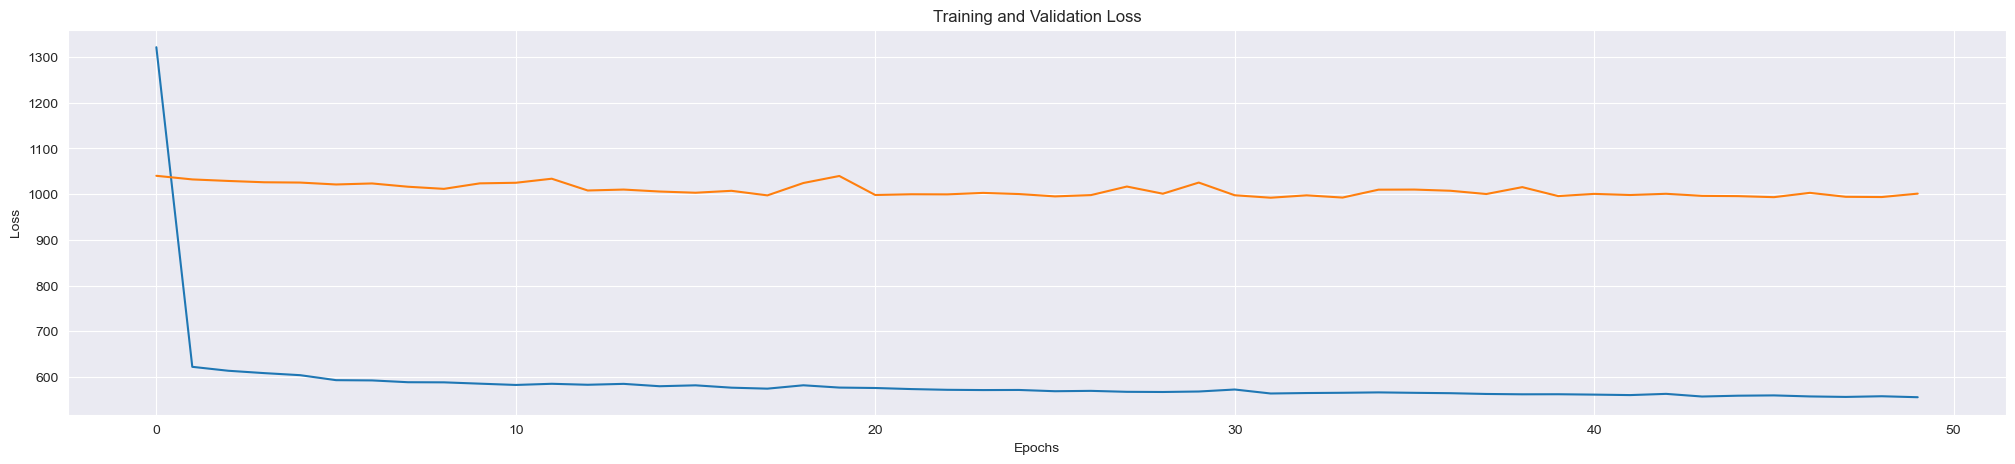

Mean Squared Error on Validation Set: 1001.5321044921875


In [18]:
# Log experiment with MlFlow

mlflow.set_experiment("Enhanced NN")

with mlflow.start_run():
    mlflow.log_param("epochs", 50)
    mlflow.log_param("learning_rate", 0.01)
    mlflow.log_param("batch_size", 512)
    
    model = train_model(model, train_loader, val_loader, epochs = 50)
    
    # Log the model
    mlflow.pytorch.log_model(model, "model")
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        predictions = model(val_dataset[:][0]).squeeze()
        mse = mean_squared_error(val_dataset[:][1], predictions.numpy())
    
    mlflow.log_metric("test_loss", mse)
    print(f'Mean Squared Error on Validation Set: {mse}')

**Observation**
- These fluctuations in training set indicates:
    - learning rate assigned is large.
    - probability of exploding gradients.
- We'll optimize this using HyperOpt

> NOTE: I observed high fluctuations with Adam Optimizer, Somehow in my experiments SGD with Momentum was getting tuned way better.

#### **Hyper Optimization using Hyperopt**

In [19]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining Tensors for optimizing on Batch Size and moving to GPU
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [20]:
import torch.nn as nn

class OptimizedNNModel(nn.Module):
    def __init__(self, input_dim, bn_momentum=0.1, bn_eps=1e-5):
        super(OptimizedNNModel, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32, momentum=bn_momentum, eps=bn_eps),
        )

        self.hidden_layer1 = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64, momentum=bn_momentum, eps=bn_eps),

        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64, momentum=bn_momentum, eps=bn_eps),

        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32, momentum=bn_momentum, eps=bn_eps),

        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32, momentum=bn_momentum, eps=bn_eps),

        )
        self.output_layer = nn.Linear(32, 1)

        self.initialize_weights()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        x = self.hidden_layer3(x)
        x = self.hidden_layer4(x)
        x = self.output_layer(x)
        return x

    def initialize_weights(self):
        for layer in self.children():
            if isinstance(layer, nn.Sequential):
                for sublayer in layer:
                    if isinstance(sublayer, nn.Linear):
                        nn.init.kaiming_uniform_(sublayer.weight, nonlinearity='relu')
                        if sublayer.bias is not None:
                            nn.init.constant_(sublayer.bias, 0)
                    elif isinstance(sublayer, nn.BatchNorm1d):
                        nn.init.constant_(sublayer.weight, 1)
                        nn.init.constant_(sublayer.bias, 0)

In [21]:
# Callback implementation for Early Stopping training, if no improvement in performance is observed

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0

In [22]:
from hyperopt import STATUS_OK
from torch.optim import SGD

def train_model(params):
    # Unpack parameters
    batch_size = int(params['batch_size'])
    learning_rate = params['learning_rate']
    epochs = int(params['epochs'])
    bn_momentum = params['bn_momentum']
    bn_eps = params['bn_eps']
    beta = params['beta1'],params['beta2']
    weight_decay = params['weight_decay']
    
    # Prepare data loaders with the given batch size
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, shuffle=False)
    
    # Initialize model
    input_dim = X_train.shape[1]
    model = OptimizedNNModel(input_dim, bn_momentum=bn_momentum, bn_eps=bn_eps).to(device)

    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate, betas =beta, weight_decay=weight_decay)
    
    # Initializing Callback EarlyStop
    early_stopping = EarlyStopping(patience=3, min_delta=0.01)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for i, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to GPU
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to GPU
                predictions = model(X_batch).squeeze()
                val_loss += criterion(predictions, y_batch).item()
        
        val_loss /= len(val_loader)

        early_stopping(val_loss)

        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

            # Evaluate on the validation set
            model.eval()
            with torch.no_grad():
                predictions = model(X_val_tensor).squeeze()
                val_loss = mean_squared_error(y_val_tensor.cpu().numpy(), predictions.cpu().numpy())
            
            return {'loss': val_loss, 'status': STATUS_OK, 'model': model}
            
        if (epoch+1) % 5 == 0: 
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')
        
    # Evaluate on the validation set
    model.eval()
    with torch.no_grad():
        predictions = model(X_val_tensor).squeeze()
        val_loss = mean_squared_error(y_val_tensor.cpu().numpy(), predictions.cpu().numpy())
    
    return {'loss': val_loss, 'status': STATUS_OK, 'model': model}

In [23]:
from hyperopt import fmin, tpe, hp, Trials

# Set the experiment name
mlflow.set_experiment("Model HyperParam Optimization")

# Hyperparameter optimization space
space = {
    'epochs': 25,
    'batch_size': hp.quniform('batch_size', 32, 2048, 32),
    'learning_rate': hp.loguniform('learning_rate', -5, -1),
    'bn_momentum': hp.uniform('bn_momentum', 0.01, 0.99),
    'bn_eps': hp.loguniform('bn_eps', -8, -1),
    'weight_decay': hp.loguniform('weight_decay', -8, -1),
    'beta1': hp.uniform('beta1', 0.6, 0.9),
    'beta2': hp.uniform('beta2', 0.9, 0.999),    
}

# Objective function for Hyperopt
def objective(params):
    with mlflow.start_run(nested=True):
        mlflow.log_params(params)
        result = train_model(params)
        mlflow.log_metric('val_loss', result['loss'])
        mlflow.pytorch.log_model(result['model'], 'model')
        return result

# Run Hyperopt optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=75, trials=trials)

print("Best parameters found: ", best)

  0%|          | 0/75 [00:02<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

#### **Fine Tuned Model**

In [74]:
batch_size= 2048
train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [122]:
import torch.nn as nn

class DeepEnhancedNNModel(nn.Module):
    def __init__(self, input_dim, bn_momentum=0.1, bn_eps=1e-5, dropout_prob=0.5):
        super(DeepEnhancedNNModel, self).__init__()

        # Input layer
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128, momentum=bn_momentum, eps=bn_eps),
            nn.Dropout(dropout_prob)
        )

        # Add more hidden layers for depth
        for _ in range(16):  # Adjust the number of layers for desired depth
            layer = 128 if _%2 else 256 
            activation = nn.ReLU if _%2 else nn.Sigmoid
            self.hidden_layers.append(nn.Sequential(
                nn.Linear(layer, layer),
                activation(),
                nn.BatchNorm1d(layer, momentum=bn_momentum, eps=bn_eps),
                nn.Dropout(dropout_prob)
            ))

        # Output layer
        self.output_layer = nn.Linear(512, 1)

        self.initialize_weights()

    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

    def initialize_weights(self):
        for layer in self.children():
            if isinstance(layer, nn.Sequential) or isinstance(layer, nn.ModuleList):
                for sublayer in layer:
                    if isinstance(sublayer, nn.Linear):
                        nn.init.kaiming_normal_(sublayer.weight, nonlinearity='relu')
                        if sublayer.bias is not None:
                            nn.init.constant_(sublayer.bias, 0)
                    elif isinstance(sublayer, nn.BatchNorm1d):
                        nn.init.constant_(sublayer.weight, 1)
                        nn.init.constant_(sublayer.bias, 0)


In [123]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [137]:
from torch.optim import SGD,Adam


def train_model():
    learning_rate = 0.005  # To handle fluctuations
    epochs = 100
    bn_momentum = 0.85
    bn_eps = 0.005
    beta = 0.71,0.92
    weight_decay = 0.0004

    input_dim = X_train.shape[1]
    model = EnhancedNNModel(input_dim, bn_momentum=bn_momentum, bn_eps=bn_eps).to(device)
    criterion = nn.SmoothL1Loss()
    optimizer = Adam(model.parameters(), lr=learning_rate, betas =beta, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4, factor=0.5, verbose=True)

    early_stopping = EarlyStopping(patience=10, min_delta=0.01)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        train_mape = 0.0
        for i, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_train_loss += loss.item()
            train_mape += mean_absolute_percentage_error(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())
        
        epoch_train_loss /= len(train_loader)
        train_mape /= len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0.0
        val_mape = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch).squeeze()
                val_loss = criterion(predictions, y_batch).item()
                epoch_val_loss += val_loss
                val_mape += mean_absolute_percentage_error(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())
        
        epoch_val_loss /= len(val_loader)
        val_mape /= len(val_loader)
        val_losses.append(epoch_val_loss)

        scheduler.step(epoch_val_loss)
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_train_loss}, Training MAPE: {train_mape}, Validation Loss: {epoch_val_loss}, Validation MAPE: {val_mape}')

        early_stopping(epoch_val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {epoch_train_loss}, Training MAPE: {train_mape}, Validation Loss: {epoch_val_loss}, Validation MAPE: {val_mape}')
            
            model.eval()
            with torch.no_grad():
                test_loss = 0.0
                test_mape = 0.0
                for X_batch, y_batch in test_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    predictions = model(X_batch).squeeze()
                    test_loss += criterion(predictions, y_batch).item()
                    test_mape += mean_absolute_percentage_error(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())
                
                test_loss /= len(test_loader)
                test_mape /= len(test_loader)
            
            return {
                'train_loss': epoch_train_loss,
                'train_mape': train_mape,
                'val_loss': epoch_val_loss,
                'val_mape': val_mape,
                'test_loss': test_loss,
                'test_mape': test_mape,
                'model': model,
                'history_train': train_losses,
                'history_val': val_losses
            }

    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_mape = 0.0
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch).squeeze()
            test_loss += criterion(predictions, y_batch).item()
            test_mape += mean_absolute_percentage_error(y_batch.cpu().numpy(), predictions.cpu().detach().numpy())
        
        test_loss /= len(test_loader)
        test_mape /= len(test_loader)
    
    return {
        'train_loss': epoch_train_loss,
        'train_mape': train_mape,
        'val_loss': epoch_val_loss,
        'val_mape': val_mape,
        'test_loss': test_loss,
        'test_mape': test_mape,
        'model': model,
        'history_train': train_losses,
        'history_val': val_losses
    }


In [138]:
mlflow.set_experiment("Optimized Final Model")

with mlflow.start_run():
    params = {
        "epochs": 100,
        "batch_size": 2048,
        "learning_rate": 0.005,
        "beta1": 0.7,
        'beta2':0.92,
        "bn_momentum": 0.85,
        "bn_eps": 0.005,
        "weight_decay":  0.0004
    }
    mlflow.log_params(params)
    result = train_model()
    mlflow.log_metric('train_loss', result['train_loss'])
    mlflow.log_metric('train_mape', result['train_mape'])
    mlflow.log_metric('val_loss', result['val_loss'])
    mlflow.log_metric('val_mape', result['val_mape'])
    mlflow.log_metric('test_loss', result['test_loss'])
    mlflow.log_metric('test_mape', result['test_mape'])
    mlflow.pytorch.log_model(result['model'], 'model')


Epoch 1/100, Training Loss: 45.890230655670166, Training MAPE: 96.96640856564045, Validation Loss: 43.929359729473404, Validation MAPE: 91.80316283152654
Epoch 2/100, Training Loss: 40.90832281112671, Training MAPE: 85.0279198338588, Validation Loss: 37.23725113501916, Validation MAPE: 75.92596663878514
Epoch 3/100, Training Loss: 32.2549219528834, Training MAPE: 64.60068052013715, Validation Loss: 26.269070625305176, Validation MAPE: 50.47635011948072
Epoch 4/100, Training Loss: 20.58544586102168, Training MAPE: 38.844856744011246, Validation Loss: 14.77720227608314, Validation MAPE: 27.483346599798935
Epoch 5/100, Training Loss: 12.532516340414682, Training MAPE: 25.140275868276756, Validation Loss: 11.583314675551195, Validation MAPE: 24.62854373913545
Epoch 6/100, Training Loss: 11.365910311539968, Training MAPE: 25.422591498742502, Validation Loss: 11.534279970022348, Validation MAPE: 25.922204554080963
Epoch 7/100, Training Loss: 11.284450451532999, Training MAPE: 25.381155374149

2024/06/20 21:31:42 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/06/20 21:31:46 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


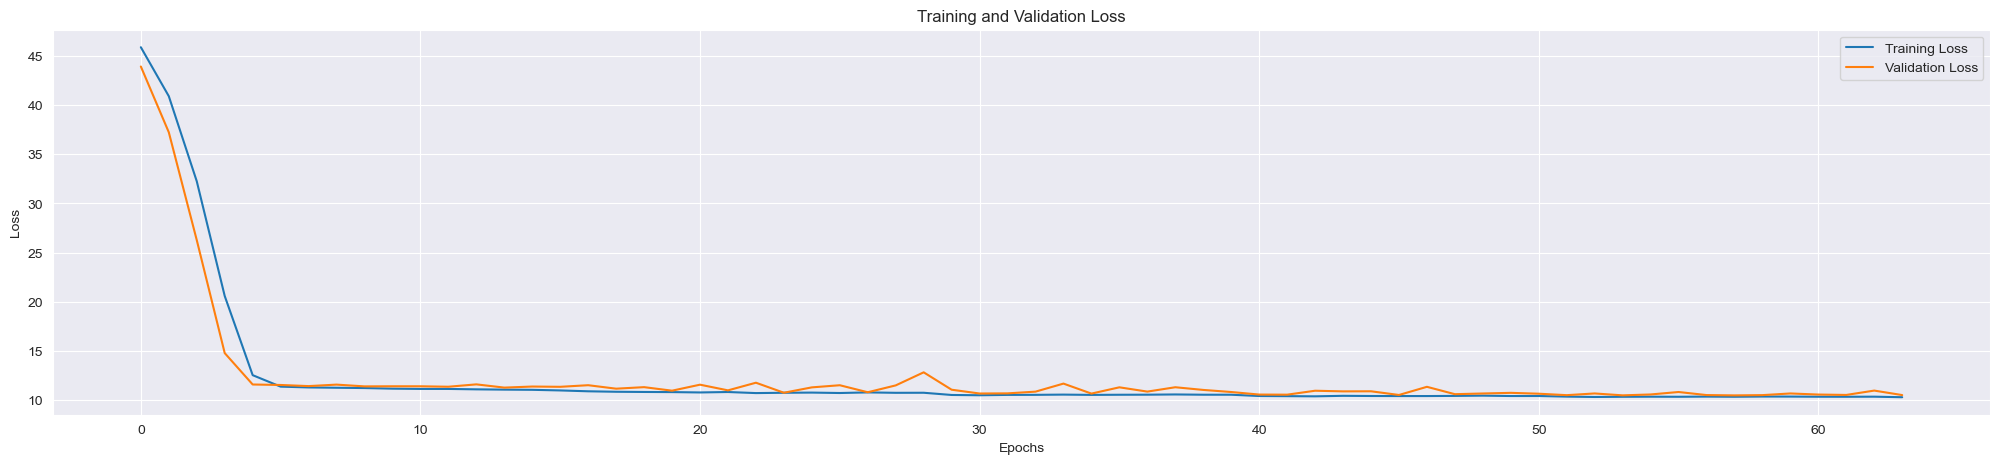

In [139]:
def plot_losses(history):
    train_losses = history['history_train']
    val_losses = history['history_val']

    plt.figure(figsize=(25, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# After training the model
plot_losses(result)


In [142]:
print("Model Huber Loss on Train:", result['train_loss'])
print("Model MAPE on Train:", result['train_mape'])

print("Model Huber Loss on Test:", result['test_loss'])
print("Model MAPE on Test:", result['test_mape'])

Model Huber Loss on Train: 10.28900029261907
Model MAPE on Train: 22.494914724181097
Model Huber Loss on Test: 10.286531900104723
Model MAPE on Test: 22.56966045028285


#### **Comparison with Gradient Boost**

In [143]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(n_estimators=128, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model.fit(X_train, y_train)

gbr_predictions = gbr_model.predict(X_val)
gbr_mape = mean_absolute_percentage_error(y_val, gbr_predictions)
print(f'Gradient Boosting Regressor MAPE: {gbr_mape:.2f}')

Gradient Boosting Regressor MAPE: 25.12


**To run MLFLOW UI**
- proxy can be accessed in studio lab by https://y0mykmepkyacvqd.studio.us-east-2.sagemaker.aws/studiolab/default/jupyter/proxy/6000/

#### **Model Explanation using Lime**

In [144]:
def predict_fn(input_data):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_data, dtype=torch.float32)
        predictions =  model(input_tensor).squeeze().cpu().detach().numpy()
    return predictions


Actual Value: 35.0
Predicted Value: 32.955578


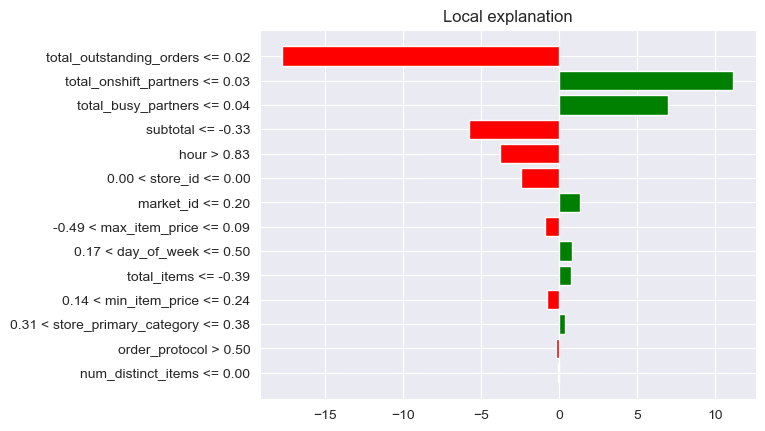

In [145]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(),
                                                   feature_names=X_train.columns.to_list(),
                                                   discretize_continuous=True,
                                                   mode='regression')

n = 7470

instance = X_test.iloc[n].to_numpy()

explanation = explainer.explain_instance(instance, predict_fn, num_features=14)

print("Actual Value:", y_test.iloc[n])
print("Predicted Value:", predict_fn([instance]))
explanation.as_pyplot_figure()
plt.show()

Actual Value: 54.0
Predicted Value: 73.38436


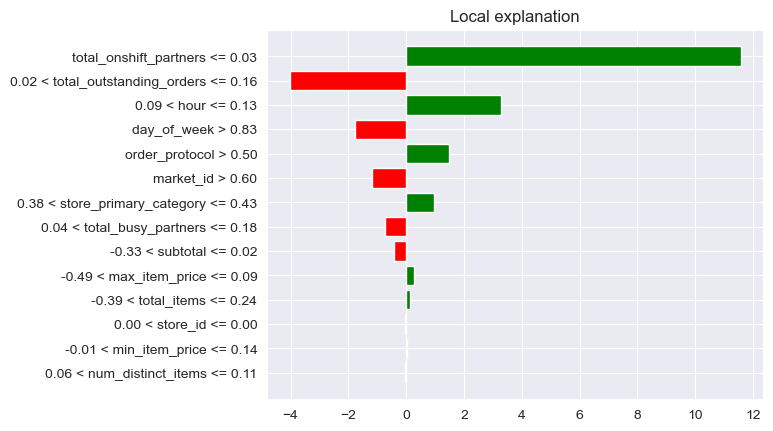

In [146]:
n = 3454

instance = X_test.iloc[n].to_numpy()

explanation = explainer.explain_instance(instance, predict_fn, num_features=14)

print("Actual Value:", y_test.iloc[n])
print("Predicted Value:", predict_fn([instance]))
explanation.as_pyplot_figure()
plt.show()

Actual Value: 53.0
Predicted Value: 55.390152


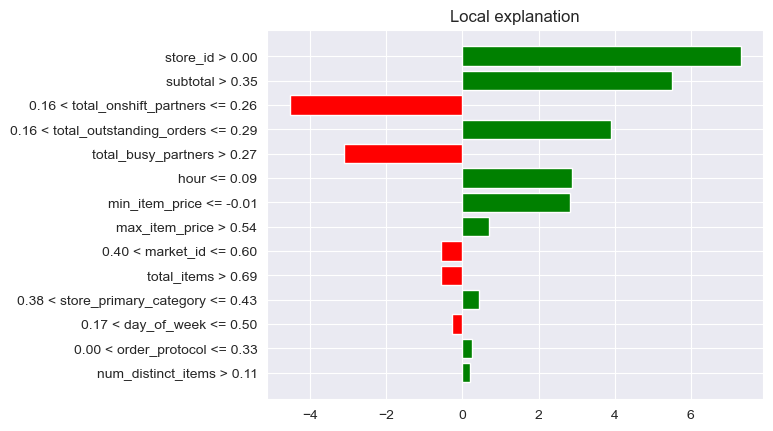

In [147]:
n = 4354

instance = X_test.iloc[n].to_numpy()

explanation = explainer.explain_instance(instance, predict_fn, num_features=14)

print("Actual Value:", y_test.iloc[n])
print("Predicted Value:", predict_fn([instance]))
explanation.as_pyplot_figure()
plt.show()

# Insights & Recommendations